In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import sys
from tqdm import tqdm
import os
%matplotlib inline

In [4]:
prometheus_endpoint = '10.9.8.136'
prometheus_port = '9090'
print("Collecting data from Monitoring at: {}".format(prometheus_endpoint))
#https://prometheus.io/docs/prometheus/latest/querying/basics/
prometheus_query = {"query": '''{__name__=~"node.+"}[40m]'''}
try:
    url = '/api/v1/query'
    resp = requests.get('http://{}:{}{}'.format(prometheus_endpoint, prometheus_port, url), params=prometheus_query)
except Exception as inst:
    print("Error fetching data")

In [5]:
def prtoDF(data,
           verbose=False,
           index=None):
    """
    From PR backend to dataframe
    :param data: PR response JSON
    :return: dataframe
    """
    if not data:
        print("No data has been received!")
        sys.exit(2)
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    if verbose:
        dr = tqdm(data['data']['result'])
    else:
        dr = data['data']['result']
    for el in dr:
        metric_name = el['metric']['__name__']
        instance_name = el['metric']['instance']
        new_metric = "{}_{}".format(metric_name, instance_name)
        values = el['values']
        proc_val = []
        proc_time = []
        for val in values:
            proc_val.append(val[1])
            proc_time.append(val[0])
        df[new_metric] = proc_val
        time_new_metric = "time_{}".format(new_metric)
        df_time[time_new_metric] = proc_time
    # Calculate the meant time for all metrics
    df_time['mean'] = df_time.mean(axis=1)
    # Round to np.ceil all metrics
    df_time['mean'] = df_time['mean'].apply(np.ceil)
    # Add the meant time to rest of metrics
    df['time'] = df_time['mean']
    print("[INFO] PR query resulted in dataframe of size: {}".format(df.shape))
    if index is not None:
        df.set_index(index, inplace=True)
        print('[WARN] PR query dataframe index set to  {}'.format( index))
    return df

df_bd_lab = prtoDF(resp.json(), verbose=True, index='time')

100%|██████████| 401/401 [00:01<00:00, 383.80it/s]


[INFO] PR query resulted in dataframe of size: (2400, 194)
[WARN] PR query dataframe index set to  time


In [6]:
df_bd_lab = df_bd_lab.astype(np.float64)

In [7]:
df_bd_lab.columns

Index(['node_arp_entries_10.211.55.101:9100',
       'node_boot_time_seconds_10.211.55.101:9100',
       'node_context_switches_total_10.211.55.101:9100',
       'node_cpu_guest_seconds_total_10.211.55.101:9100',
       'node_cpu_seconds_total_10.211.55.101:9100',
       'node_disk_io_now_10.211.55.101:9100',
       'node_disk_io_time_seconds_total_10.211.55.101:9100',
       'node_disk_io_time_weighted_seconds_total_10.211.55.101:9100',
       'node_disk_read_bytes_total_10.211.55.101:9100',
       'node_disk_read_time_seconds_total_10.211.55.101:9100',
       ...
       'node_timex_tai_offset_seconds_10.211.55.101:9100',
       'node_timex_tick_seconds_10.211.55.101:9100',
       'node_uname_info_10.211.55.101:9100',
       'node_vmstat_oom_kill_10.211.55.101:9100',
       'node_vmstat_pgfault_10.211.55.101:9100',
       'node_vmstat_pgmajfault_10.211.55.101:9100',
       'node_vmstat_pgpgin_10.211.55.101:9100',
       'node_vmstat_pgpgout_10.211.55.101:9100',
       'node_vmstat_psw

<AxesSubplot:xlabel='time'>

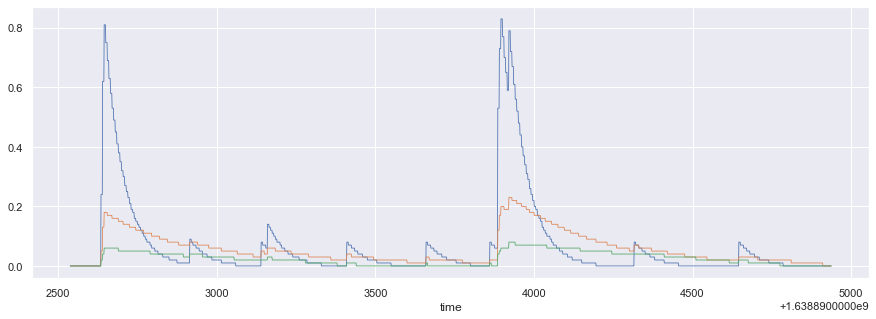

In [8]:
sns.set(rc={'figure.figsize':(15, 5)})
df_bd_lab["node_load1_10.211.55.101:9100"].plot(linewidth=0.8)
df_bd_lab["node_load5_10.211.55.101:9100"].plot(linewidth=0.8)
df_bd_lab["node_load15_10.211.55.101:9100"].plot(linewidth=0.8)
# df_bd_lab["node_load1_10.211.55.101:9100"].plot(linewidth=0.8)

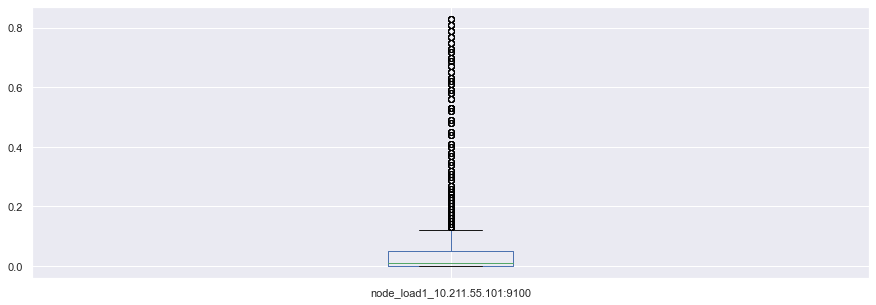

In [9]:
df_bd_lab["node_load1_10.211.55.101:9100"].plot.box();


In [10]:
df_bd_lab.columns


Index(['node_arp_entries_10.211.55.101:9100',
       'node_boot_time_seconds_10.211.55.101:9100',
       'node_context_switches_total_10.211.55.101:9100',
       'node_cpu_guest_seconds_total_10.211.55.101:9100',
       'node_cpu_seconds_total_10.211.55.101:9100',
       'node_disk_io_now_10.211.55.101:9100',
       'node_disk_io_time_seconds_total_10.211.55.101:9100',
       'node_disk_io_time_weighted_seconds_total_10.211.55.101:9100',
       'node_disk_read_bytes_total_10.211.55.101:9100',
       'node_disk_read_time_seconds_total_10.211.55.101:9100',
       ...
       'node_timex_tai_offset_seconds_10.211.55.101:9100',
       'node_timex_tick_seconds_10.211.55.101:9100',
       'node_uname_info_10.211.55.101:9100',
       'node_vmstat_oom_kill_10.211.55.101:9100',
       'node_vmstat_pgfault_10.211.55.101:9100',
       'node_vmstat_pgmajfault_10.211.55.101:9100',
       'node_vmstat_pgpgin_10.211.55.101:9100',
       'node_vmstat_pgpgout_10.211.55.101:9100',
       'node_vmstat_psw

<AxesSubplot:xlabel='time'>

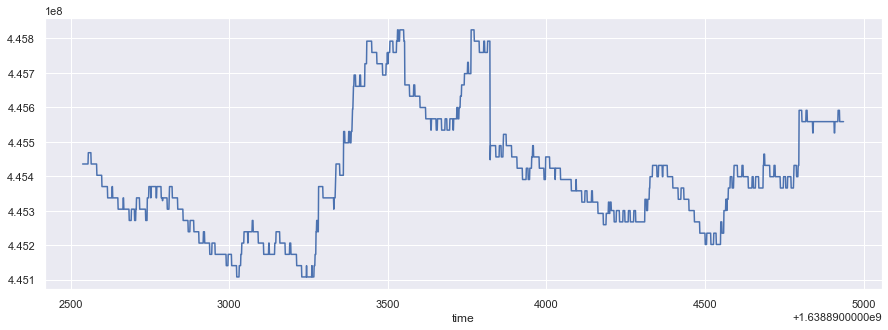

In [11]:
df_bd_lab["node_memory_MemFree_bytes_10.211.55.101:9100"].plot()


In [12]:
# df_bd_lab.fillna(0.0, inplace=True)
df_bd_lab.dropna(axis=1, inplace=True)

In [13]:
df_bd_lab.shape

(2400, 193)

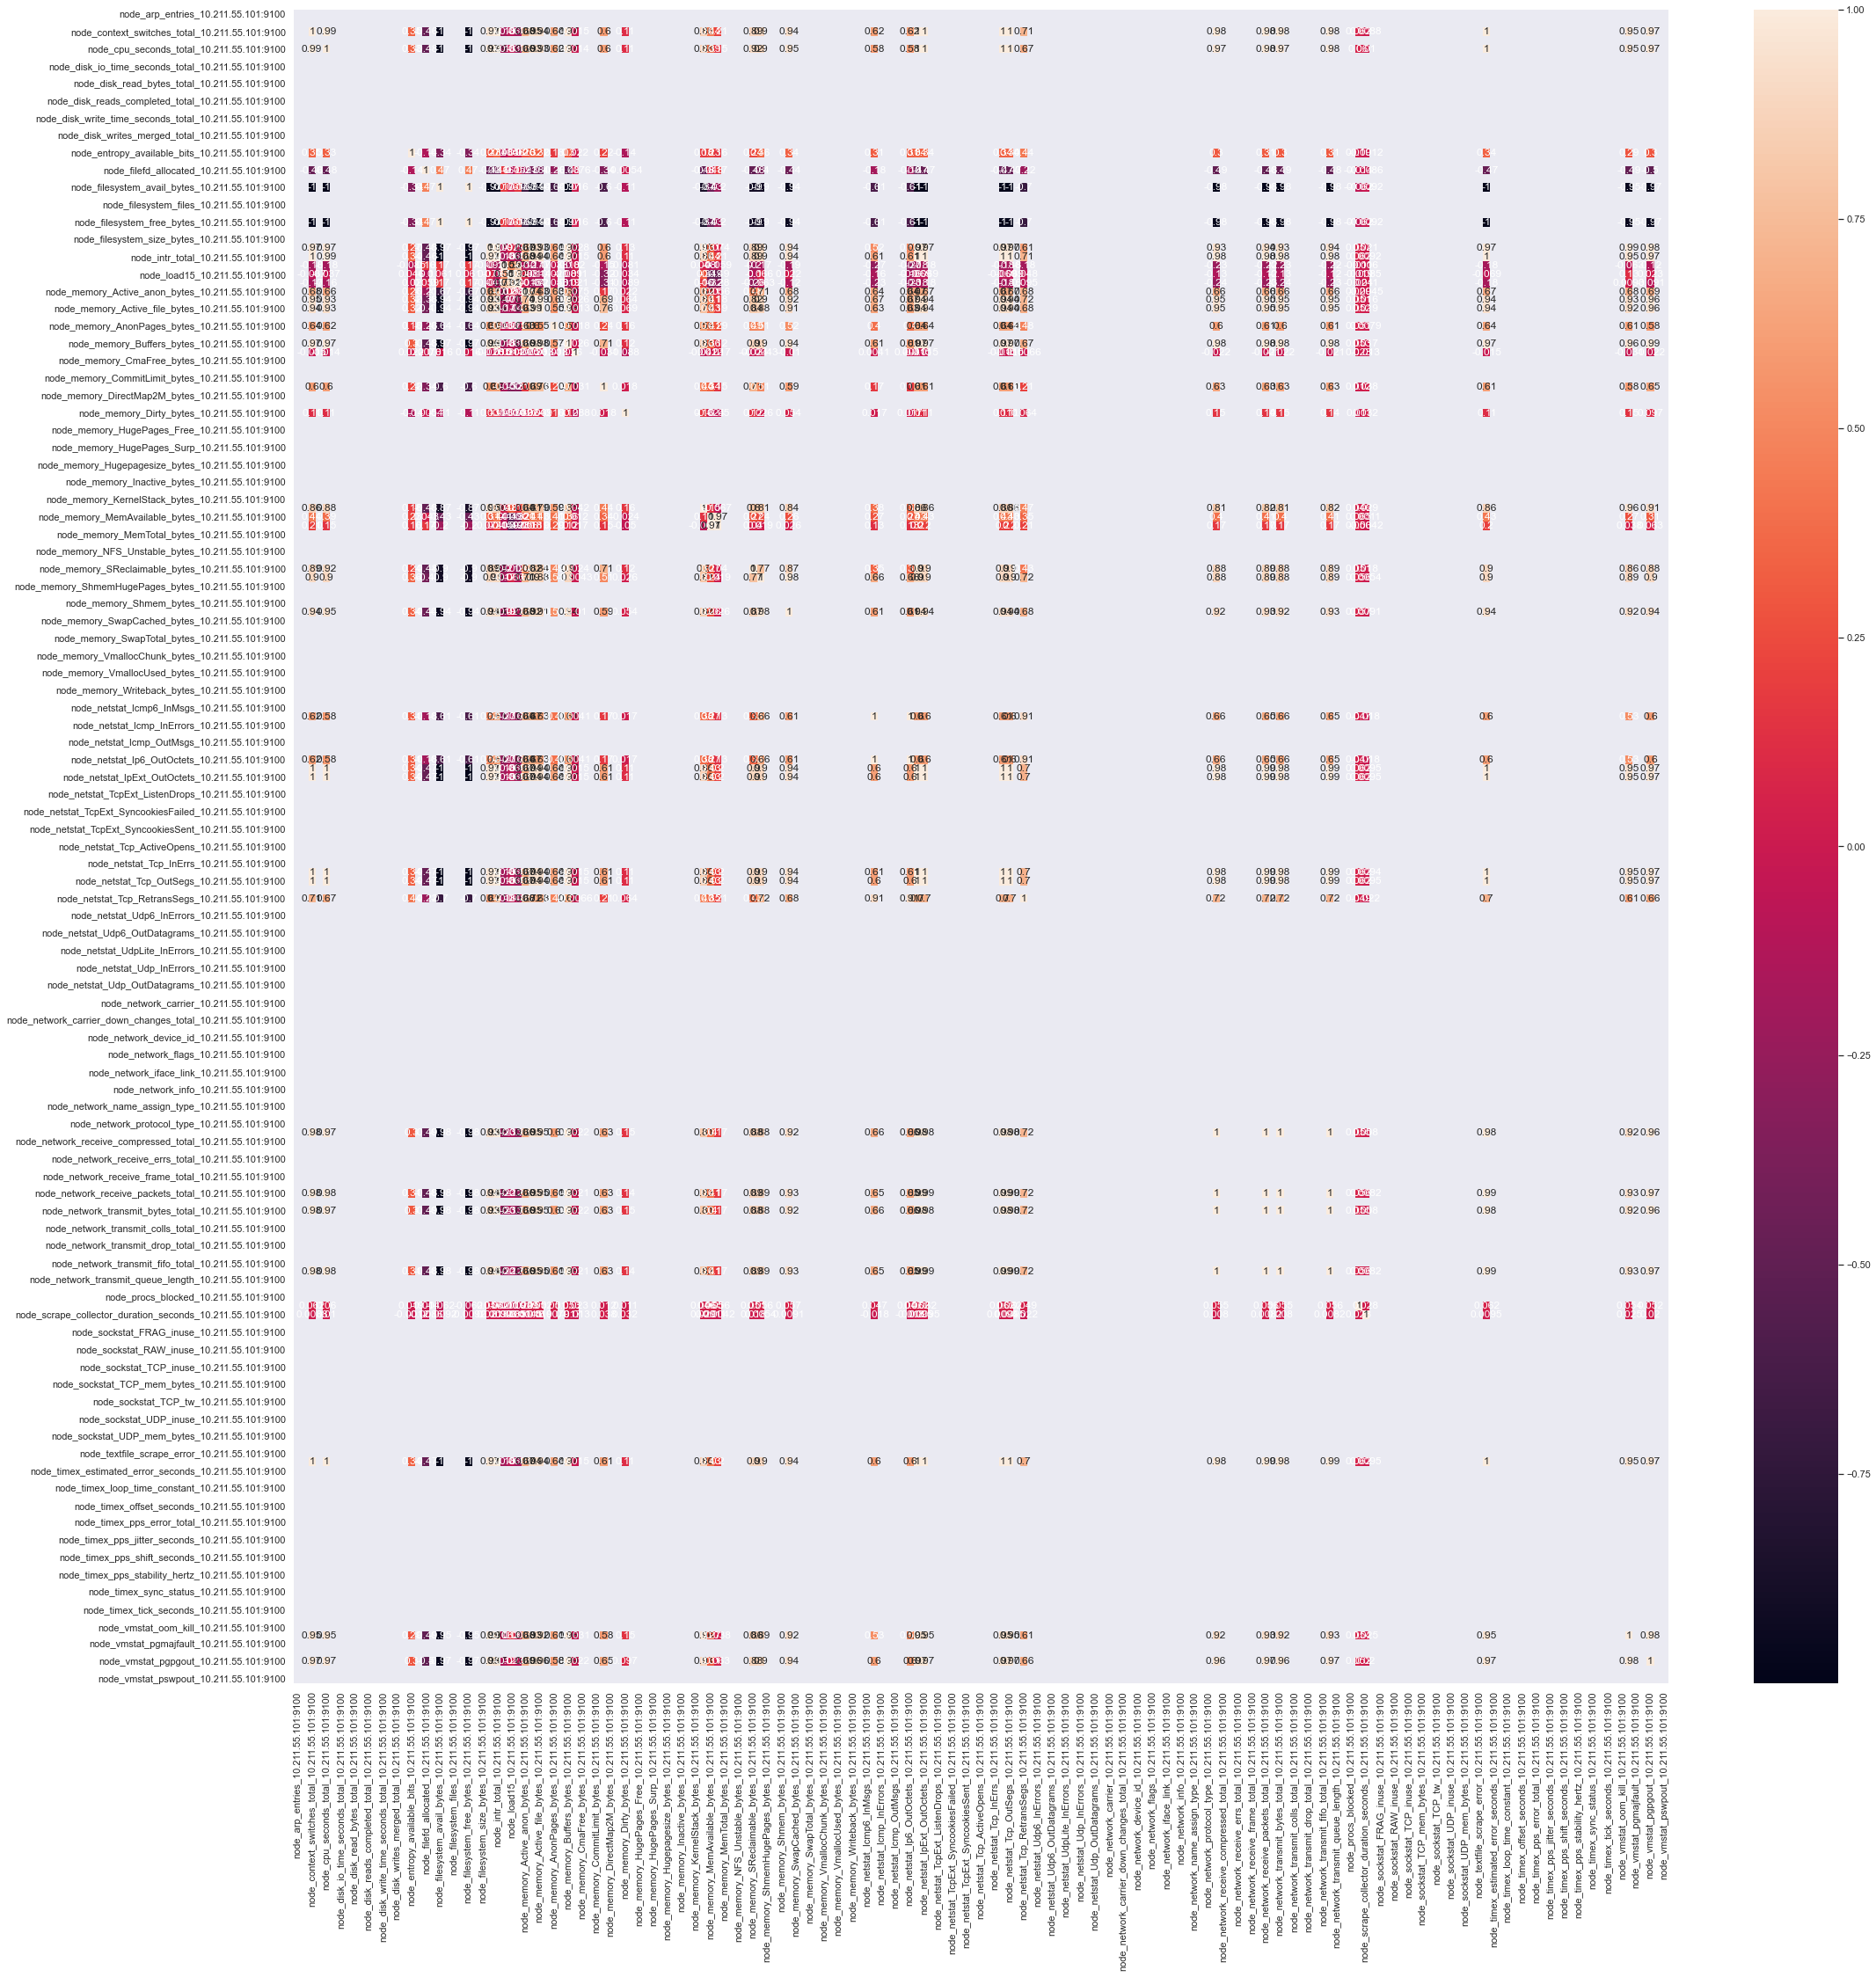

In [14]:
# Pearson correlation
plt.subplots(figsize=(35, 35))
sns.heatmap(df_bd_lab.corr(), annot=True)
plt.show()


In [15]:
uniques_au_a = df_bd_lab.apply(lambda x: x.nunique())
rm_columns = []
for uindex, uvalue in uniques_au_a.iteritems():
    if uvalue == 1:
        rm_columns.append(uindex)

print("Columns to be removed: {}".format(rm_columns))
print("Total: {}".format(len(rm_columns)))



Columns to be removed: ['node_arp_entries_10.211.55.101:9100', 'node_boot_time_seconds_10.211.55.101:9100', 'node_cpu_guest_seconds_total_10.211.55.101:9100', 'node_disk_io_now_10.211.55.101:9100', 'node_disk_io_time_seconds_total_10.211.55.101:9100', 'node_disk_io_time_weighted_seconds_total_10.211.55.101:9100', 'node_disk_read_bytes_total_10.211.55.101:9100', 'node_disk_read_time_seconds_total_10.211.55.101:9100', 'node_disk_reads_completed_total_10.211.55.101:9100', 'node_disk_reads_merged_total_10.211.55.101:9100', 'node_disk_write_time_seconds_total_10.211.55.101:9100', 'node_disk_writes_completed_total_10.211.55.101:9100', 'node_disk_writes_merged_total_10.211.55.101:9100', 'node_disk_written_bytes_total_10.211.55.101:9100', 'node_exporter_build_info_10.211.55.101:9100', 'node_filefd_maximum_10.211.55.101:9100', 'node_filesystem_device_error_10.211.55.101:9100', 'node_filesystem_files_10.211.55.101:9100', 'node_filesystem_files_free_10.211.55.101:9100', 'node_filesystem_readonly_

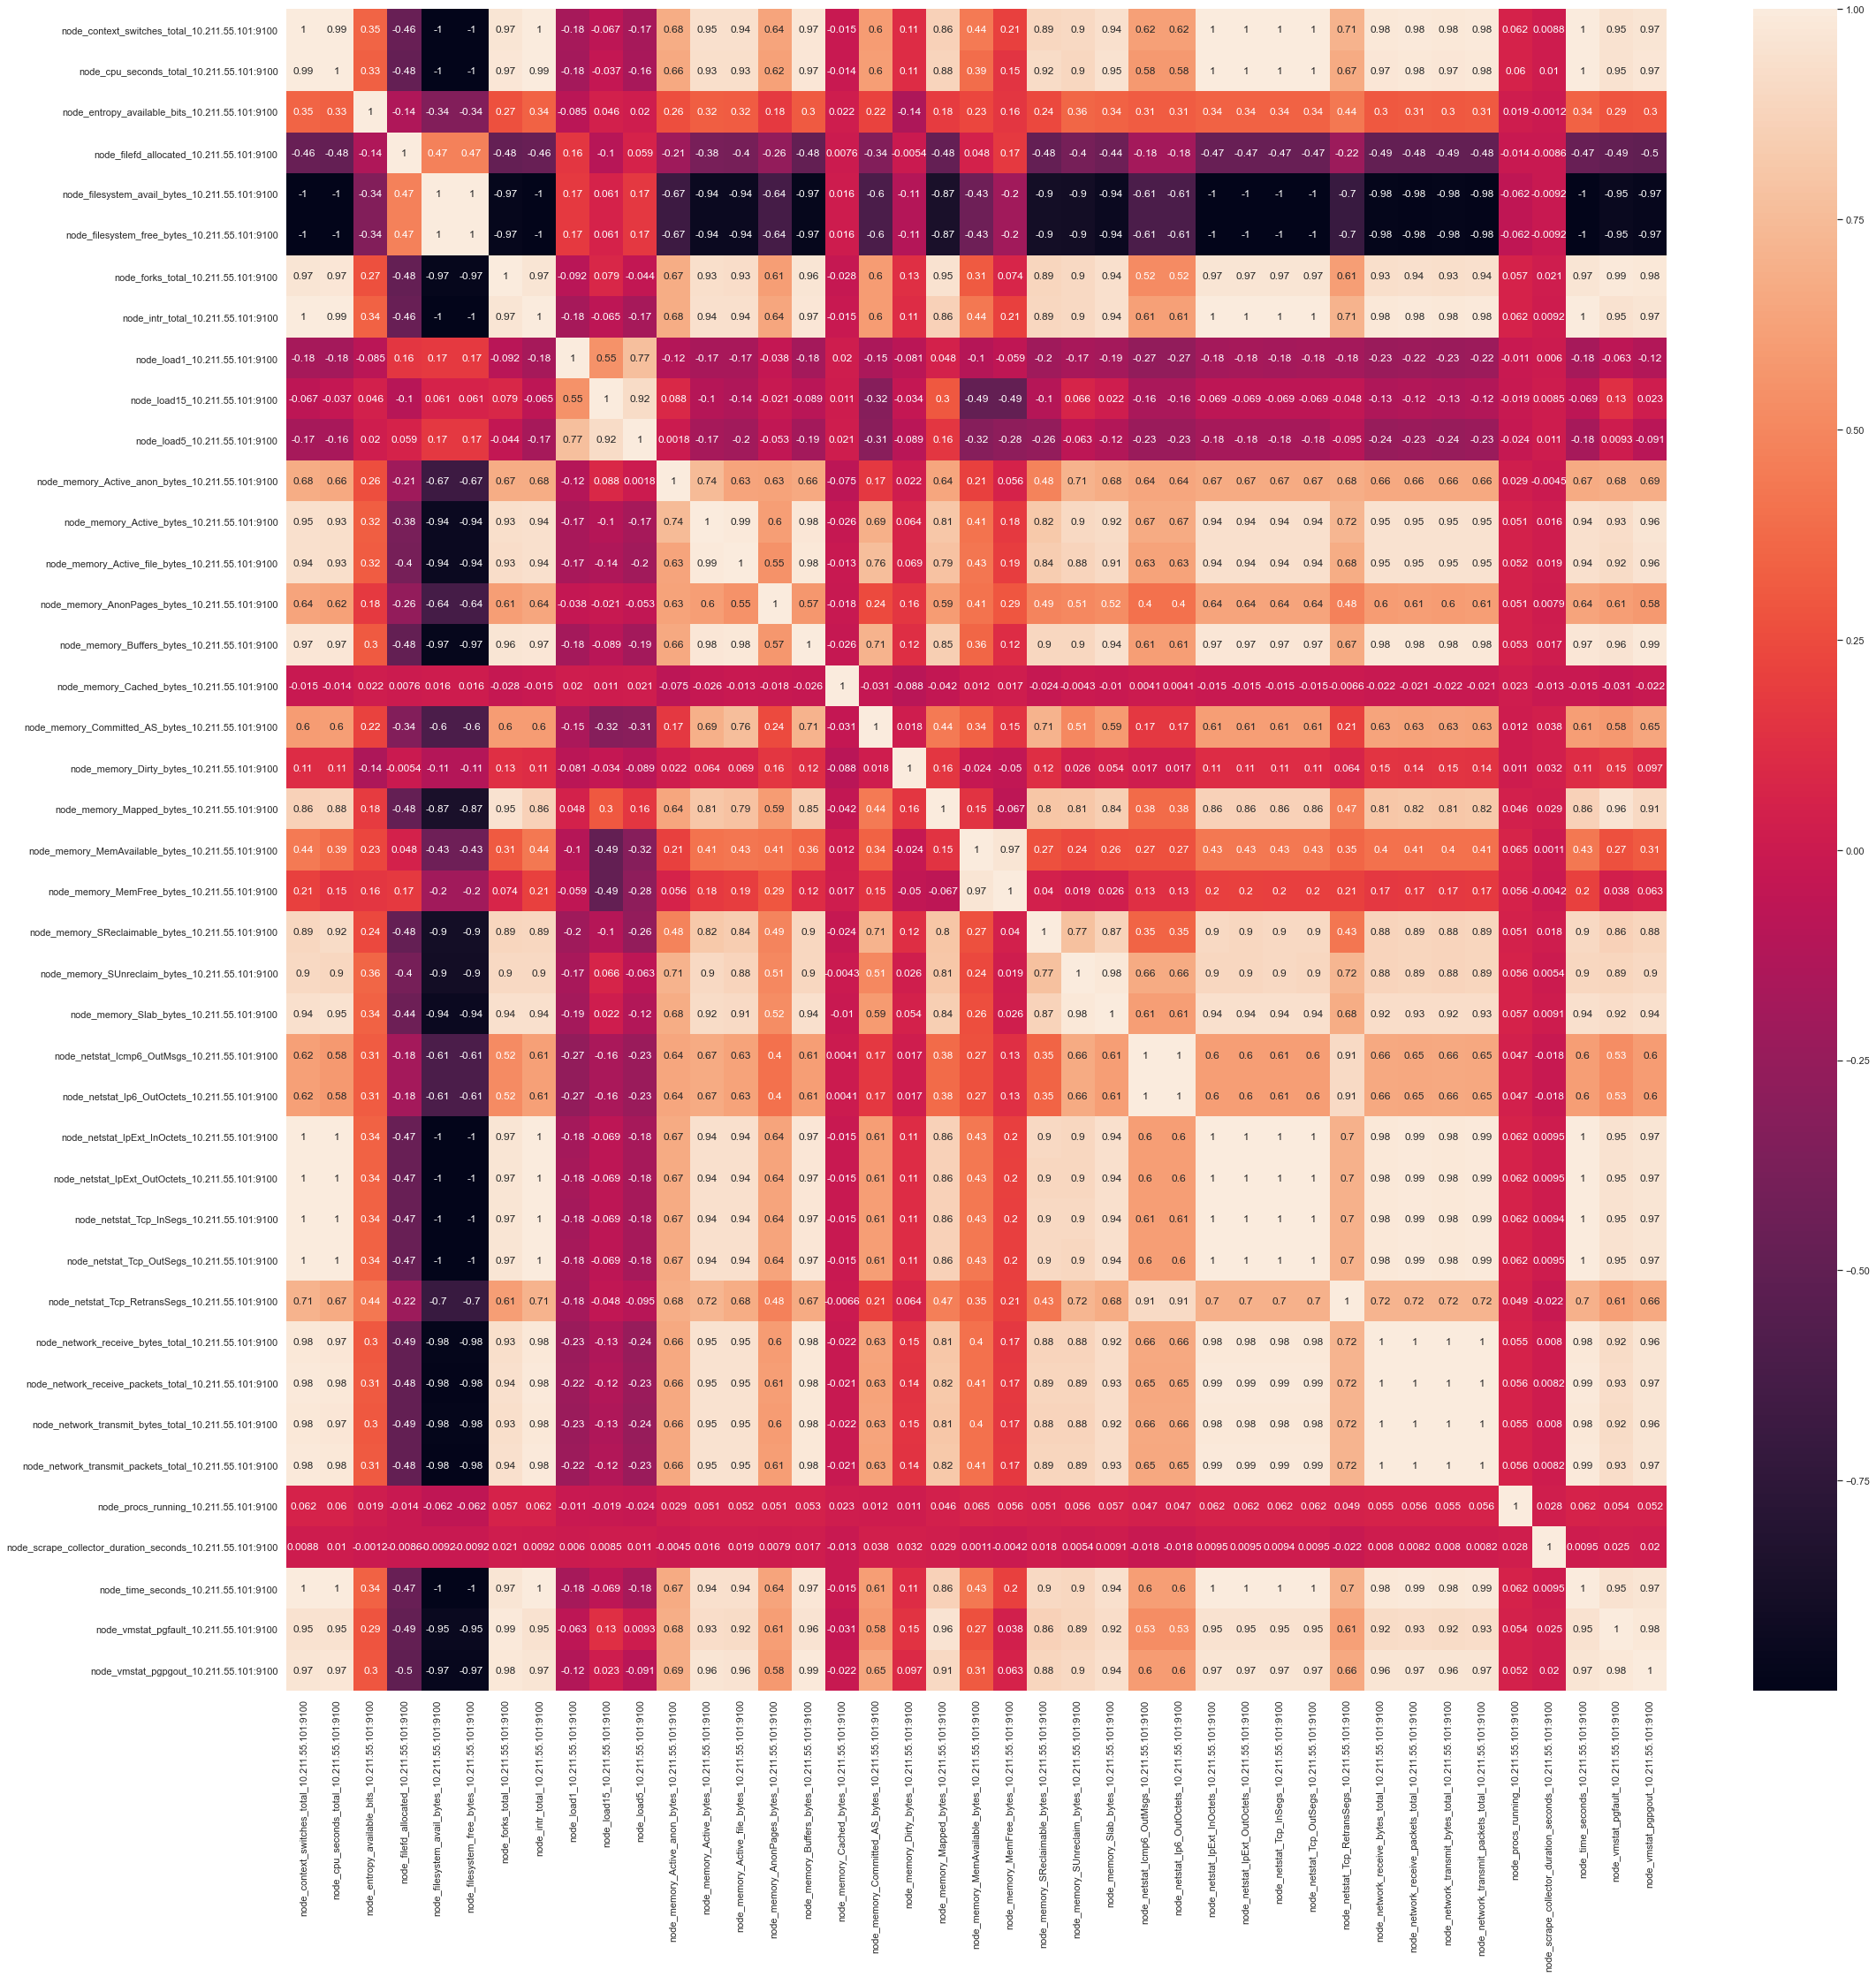

In [16]:
df_bd_lab_rm =  df_bd_lab.drop(rm_columns, axis=1)
# Pearson correlation
plt.subplots(figsize=(35, 35))
sns.heatmap(df_bd_lab_rm.corr(), annot=True)
plt.show()

In [20]:
from sklearn.ensemble import IsolationForest
# 

In [21]:
clf = IsolationForest(
n_estimators=10,
    contamination=0.05,
)

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_bd_lab_rm_scaled_np = scaler.fit_transform(df_bd_lab_rm)

In [30]:

df_bd_lab_rm_scaled = pd.DataFrame(df_bd_lab_rm_scaled_np, index=df_bd_lab_rm.index, columns=df_bd_lab_rm.columns)
df_bd_lab_rm_scaled

node_context_switches_total_10.211.55.101:9100  \
time                                                           
1.638893e+09                                        0.000000   
1.638893e+09                                        0.000661   
1.638893e+09                                        0.001003   
1.638893e+09                                        0.001379   
1.638893e+09                                        0.001878   
...                                                      ...   
1.638895e+09                                        0.998107   
1.638895e+09                                        0.998723   
1.638895e+09                                        0.999067   
1.638895e+09                                        0.999526   
1.638895e+09                                        1.000000   

              node_cpu_seconds_total_10.211.55.101:9100  \
time                                                      
1.638893e+09                                   0.000000   
1.638893e+09                                   0.000881   
1.638893e+09                                   0.000881   
1.638893e+09                                   0.001762   
1.638893e+09                                   0.001762   
...                                                 ...   
1.638895e+09                                   0.999119   
1.638895e+09                                   0.999119   
1.638895e+09                                   0.999119   
1.638895e+09                                   1.000000   
1.638895e+09                                   1.000000   

              node_entropy_available_bits_10.211.55.101:9100  \
time                                                           
1.638893e+09                                        0.000000   
1.638893e+09                                        0.002793   
1.638893e+09                                        0.005587   
1.638893e+09                                        0.008380   
1.638893e+09                                        0.008380   
...                                                      ...   
1.638895e+09                                        0.642458   
1.638895e+09                                        0.645251   
1.638895e+09                                        0.645251   
1.638895e+09                                        0.648045   
1.638895e+09                                        0.650838   

              node_filefd_allocated_10.211.55.101:9100  \
time                                                     
1.638893e+09                                       1.0   
1.638893e+09                                       1.0   
1.638893e+09                                       1.0   
1.638893e+09                                       1.0   
1.638893e+09                                       1.0   
...                                                ...   
1.638895e+09                                       1.0   
1.638895e+09                                       1.0   
1.638895e+09                                       1.0   
1.638895e+09                                       1.0   
1.638895e+09                                       1.0   

              node_filesystem_avail_bytes_10.211.55.101:9100  \
time                                                           
1.638893e+09                                        1.000000   
1.638893e+09                                        1.000000   
1.638893e+09                                        1.000000   
1.638893e+09                                        1.000000   
1.638893e+09                                        1.000000   
...                                                      ...   
1.638895e+09                                        0.004651   
1.638895e+09                                        0.000000   
1.638895e+09                                        0.000000   
1.638895e+09                                        0.000000   
1.638895e+09                                        0.000

In [31]:
clf.fit(df_bd_lab_rm_scaled)

IsolationForest(contamination=0.05, n_estimators=10)

In [32]:
pred = clf.predict(df_bd_lab_rm_scaled)
pred

array([-1, -1, -1, ..., -1, -1, -1])

In [35]:
print(f"Number of anomalies {list(pred).count(-1)} from a total event count {len(list(pred)), }")

Number of anomalies 119 from a total event count (2400,)


In [37]:
anomaly_index = np.where(pred==-1)
anomaly_index

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   38,   39,   40,   42,   52,   55,
          56,   62,   64,   70,   74,   75,   76,   77,   78,   79,   83,
         252,  255,  256,  302,  303,  304,  305,  306,  308,  363,  602,
        1285, 1287, 1290, 1922, 2054, 2059, 2060, 2064, 2073, 2076, 2086,
        2119, 2120, 2222, 2316, 2327, 2333, 2335, 2338, 2346, 2350, 2351,
        2352, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2362, 2364, 2365,
        2367, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379,
        2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390,
        2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399]),)

In [38]:
from sklearn.decomposition import PCA
tranformer = PCA(n_components=2)

In [41]:
tranformer.fit(df_bd_lab_rm_scaled)
X_transformed = tranformer.transform(df_bd_lab_rm_scaled)

In [42]:
X_transformed

array([[ 2.52267818,  0.34702086],
       [ 2.52283147,  0.34885876],
       [ 2.52212627,  0.34879917],
       ...,
       [-2.52108397, -0.21732502],
       [-2.52199041, -0.2176668 ],
       [-2.52214452, -0.21685297]])

In [43]:
values_2c = X_transformed[anomaly_index]
values_2c

array([[ 2.52267818,  0.34702086],
       [ 2.52283147,  0.34885876],
       [ 2.52212627,  0.34879917],
       [ 2.5210029 ,  0.35018408],
       [ 2.520579  ,  0.34848942],
       [ 2.51296368,  0.3482808 ],
       [ 2.50925192,  0.34353804],
       [ 2.50753966,  0.34132845],
       [ 2.50796999,  0.34283603],
       [ 2.50523074,  0.3430444 ],
       [ 2.50398124,  0.34162176],
       [ 2.5041791 ,  0.34341528],
       [ 2.5023239 ,  0.3412889 ],
       [ 2.50400753,  0.34505129],
       [ 2.50266684,  0.34408703],
       [ 2.50054221,  0.34191912],
       [ 2.50041323,  0.34271512],
       [ 2.49962433,  0.34266078],
       [ 2.49398095,  0.31531247],
       [ 2.49155208,  0.31540231],
       [ 2.49087768,  0.315266  ],
       [ 2.48939601,  0.31408624],
       [ 2.48975509,  0.31573309],
       [ 2.48866187,  0.31472006],
       [ 2.48731104,  0.31357539],
       [ 2.48703796,  0.31537388],
       [ 2.48684248,  0.31536277],
       [ 2.52829057,  0.31641879],
       [ 2.52457369,

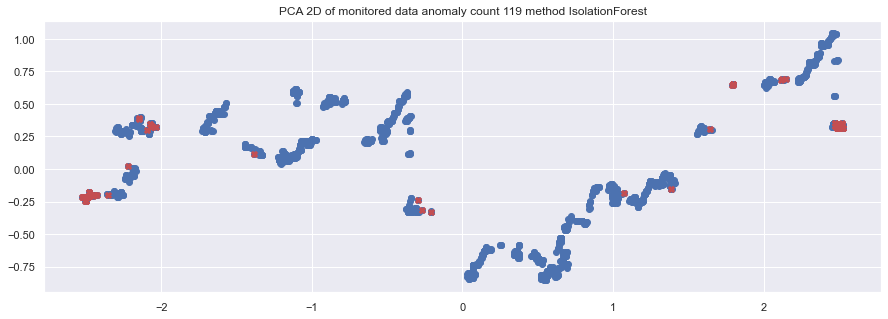

In [50]:
plt.scatter(X_transformed[:,0], X_transformed[:,1])
plt.scatter(values_2c[:,0], values_2c[:,1], color='r', marker='X')
plt.title(f"PCA 2D of monitored data anomaly count {list(pred).count(-1)} method IsolationForest")
plt.show()

In [58]:
tranformer_3d = PCA(n_components=3)
tranformer_3d.fit(df_bd_lab_rm_scaled)
X_transformed_3 = tranformer_3d.transform(df_bd_lab_rm_scaled)
values_3c = X_transformed_3[anomaly_index]
values_3c

array([[ 2.52267818e+00,  3.47020865e-01,  1.01851822e+00],
       [ 2.52283147e+00,  3.48858758e-01,  1.01844668e+00],
       [ 2.52212627e+00,  3.48799172e-01,  1.01838163e+00],
       [ 2.52100290e+00,  3.50184085e-01,  1.01965529e+00],
       [ 2.52057900e+00,  3.48489423e-01,  1.01808772e+00],
       [ 2.51296368e+00,  3.48280798e-01,  1.01462994e+00],
       [ 2.50925192e+00,  3.43538038e-01,  1.00858732e+00],
       [ 2.50753966e+00,  3.41328452e-01,  1.00830659e+00],
       [ 2.50796999e+00,  3.42836033e-01,  1.00794322e+00],
       [ 2.50523074e+00,  3.43044399e-01,  1.00811663e+00],
       [ 2.50398124e+00,  3.41621762e-01,  1.00765815e+00],
       [ 2.50417910e+00,  3.43415279e-01,  1.00754335e+00],
       [ 2.50232390e+00,  3.41288904e-01,  1.00731004e+00],
       [ 2.50400753e+00,  3.45051286e-01,  1.00728765e+00],
       [ 2.50266684e+00,  3.44087029e-01,  1.00726043e+00],
       [ 2.50054221e+00,  3.41919118e-01,  1.00697074e+00],
       [ 2.50041323e+00,  3.42715123e-01

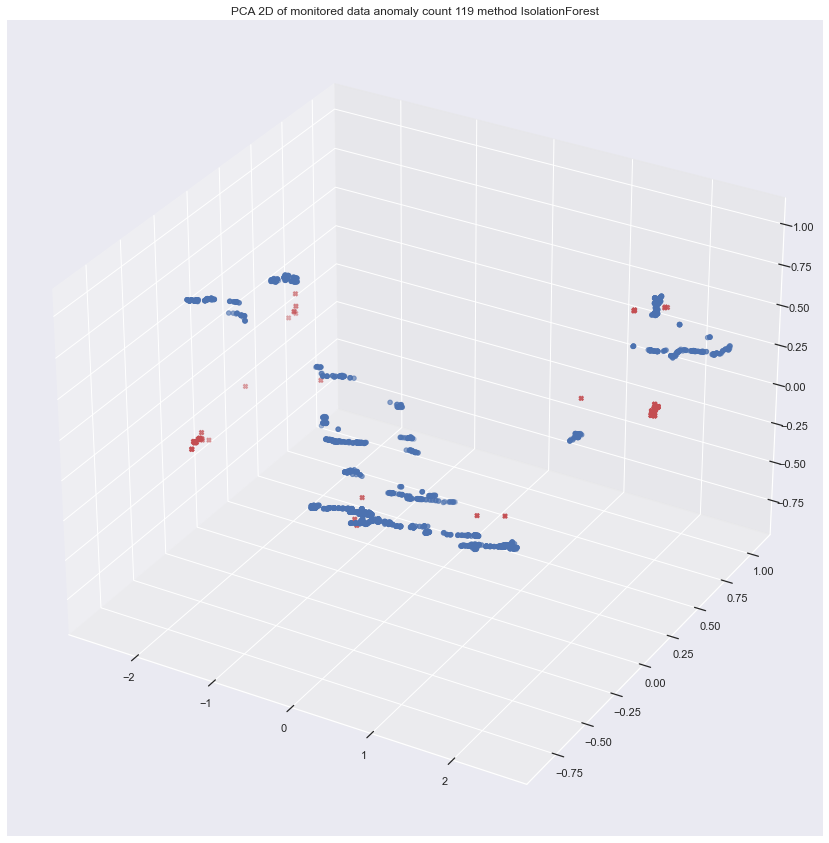

In [60]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_transformed_3[:,0], X_transformed_3[:,1], zs=X_transformed_3[:,2], label="Normal")
ax.scatter(values_3c[:,0], values_3c[:,1], values_3c[:,1], label="Anomaly", color='r', marker='X')
plt.title(f"PCA 2D of monitored data anomaly count {list(pred).count(-1)} method IsolationForest")
plt.show()

In [61]:
df_plot = df_bd_lab_rm_scaled
print(df_plot.columns.values)





['node_context_switches_total_10.211.55.101:9100'
 'node_cpu_seconds_total_10.211.55.101:9100'
 'node_entropy_available_bits_10.211.55.101:9100'
 'node_filefd_allocated_10.211.55.101:9100'
 'node_filesystem_avail_bytes_10.211.55.101:9100'
 'node_filesystem_free_bytes_10.211.55.101:9100'
 'node_forks_total_10.211.55.101:9100'
 'node_intr_total_10.211.55.101:9100' 'node_load1_10.211.55.101:9100'
 'node_load15_10.211.55.101:9100' 'node_load5_10.211.55.101:9100'
 'node_memory_Active_anon_bytes_10.211.55.101:9100'
 'node_memory_Active_bytes_10.211.55.101:9100'
 'node_memory_Active_file_bytes_10.211.55.101:9100'
 'node_memory_AnonPages_bytes_10.211.55.101:9100'
 'node_memory_Buffers_bytes_10.211.55.101:9100'
 'node_memory_Cached_bytes_10.211.55.101:9100'
 'node_memory_Committed_AS_bytes_10.211.55.101:9100'
 'node_memory_Dirty_bytes_10.211.55.101:9100'
 'node_memory_Mapped_bytes_10.211.55.101:9100'
 'node_memory_MemAvailable_bytes_10.211.55.101:9100'
 'node_memory_MemFree_bytes_10.211.55.101:

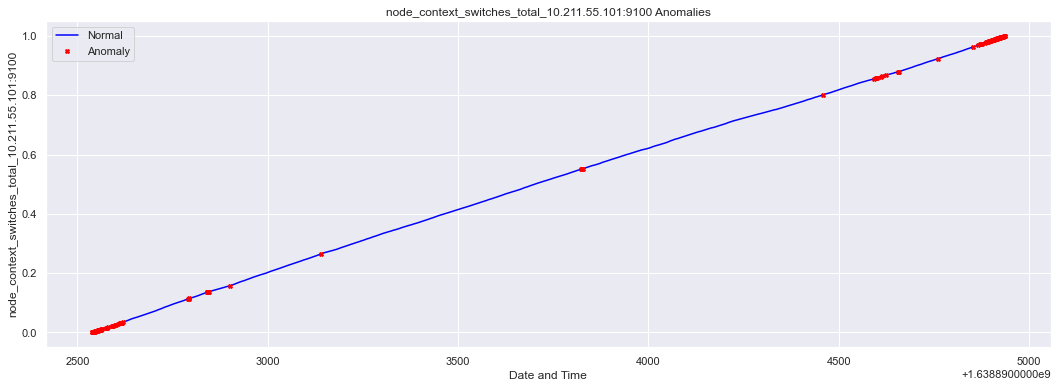

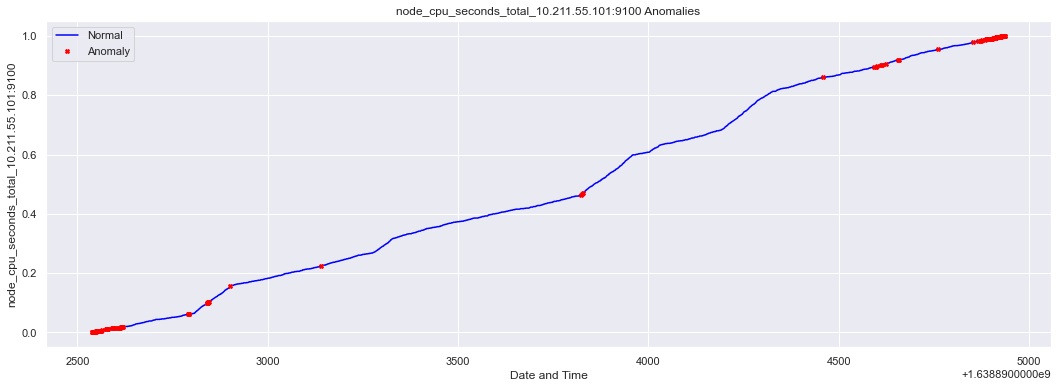

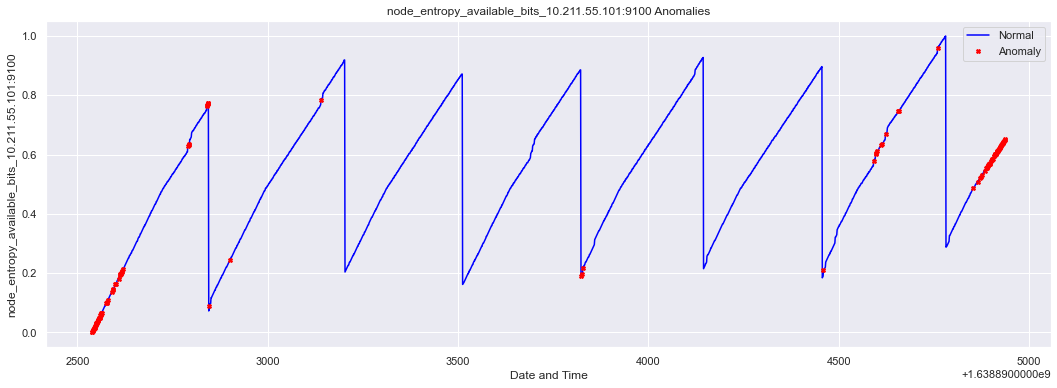

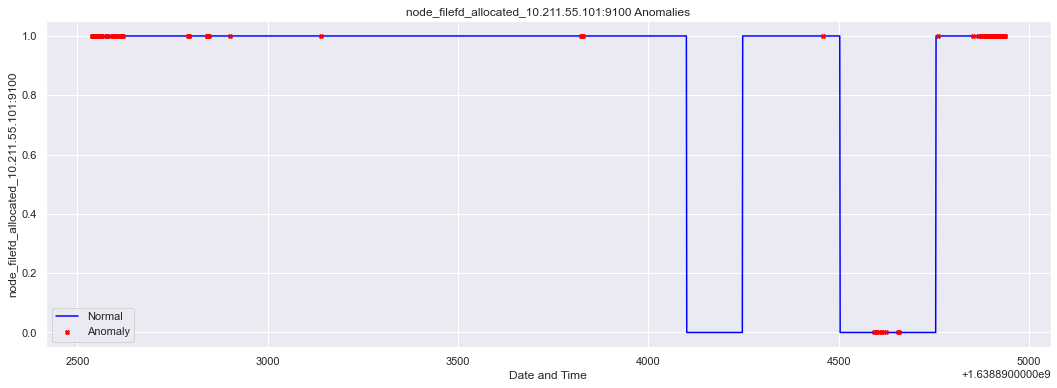

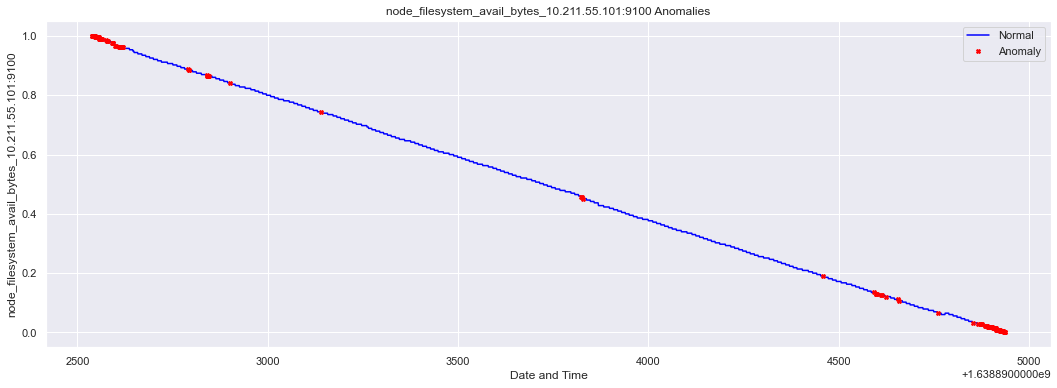

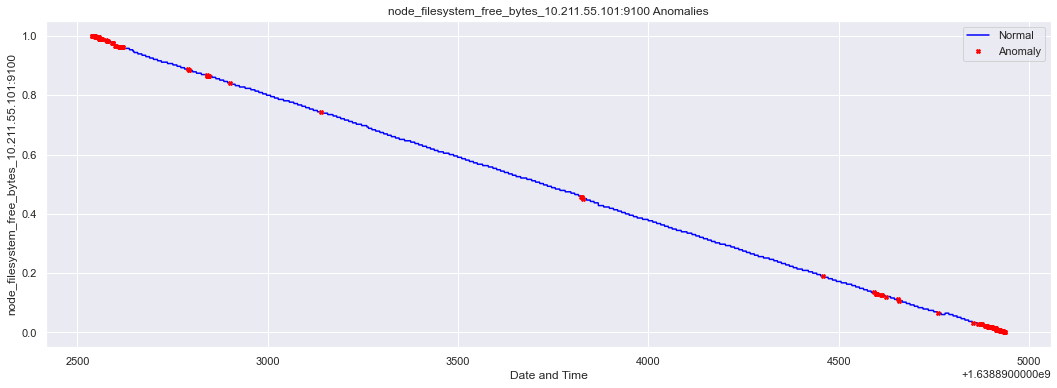

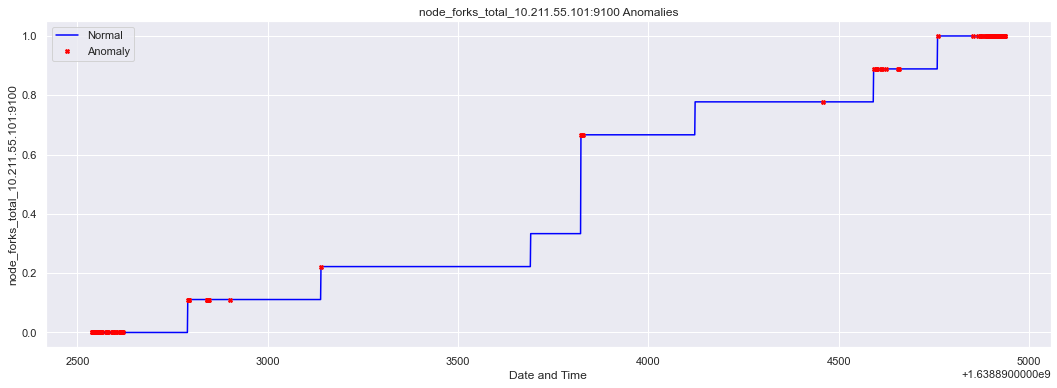

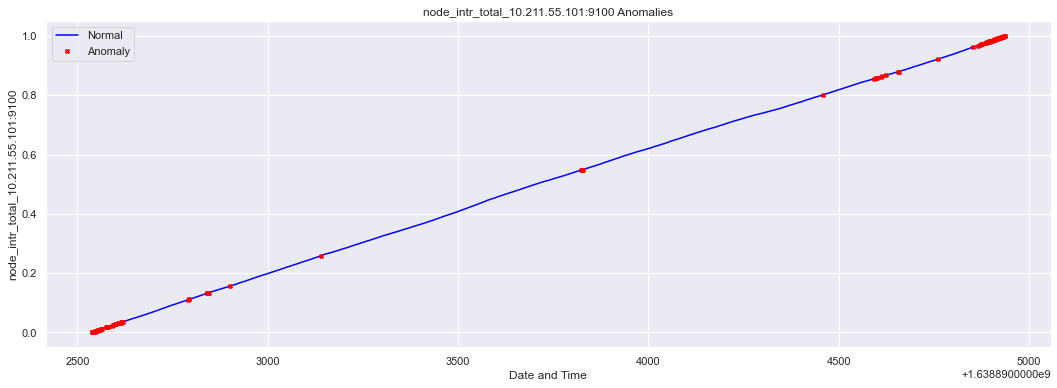

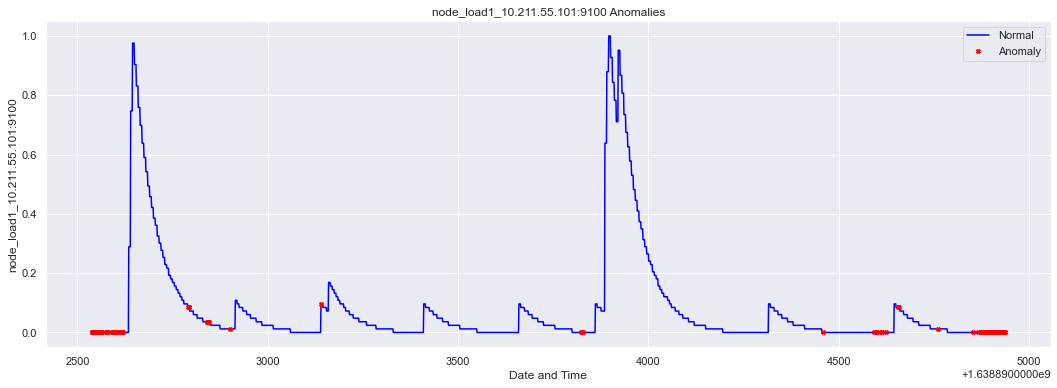

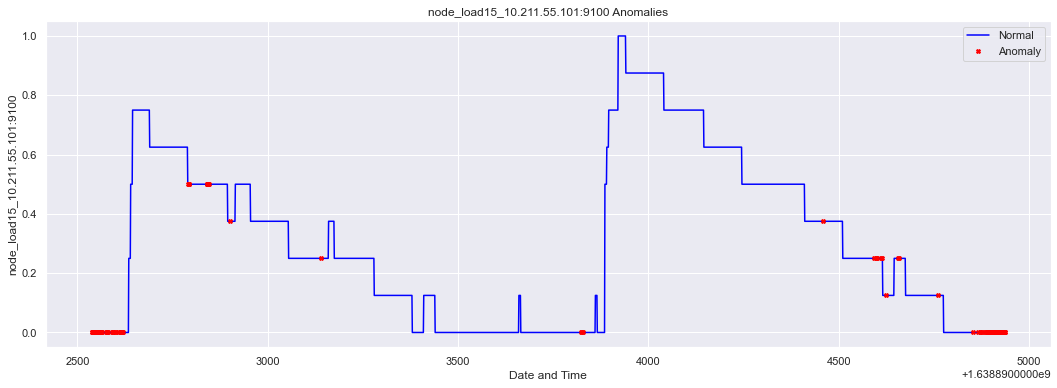

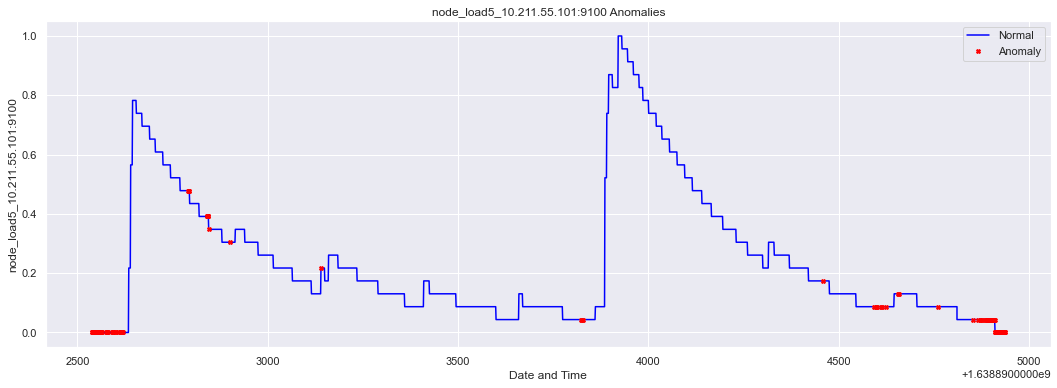

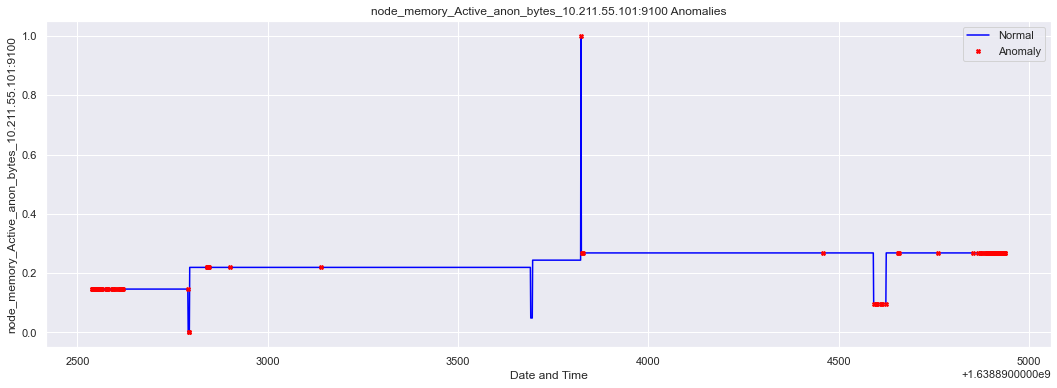

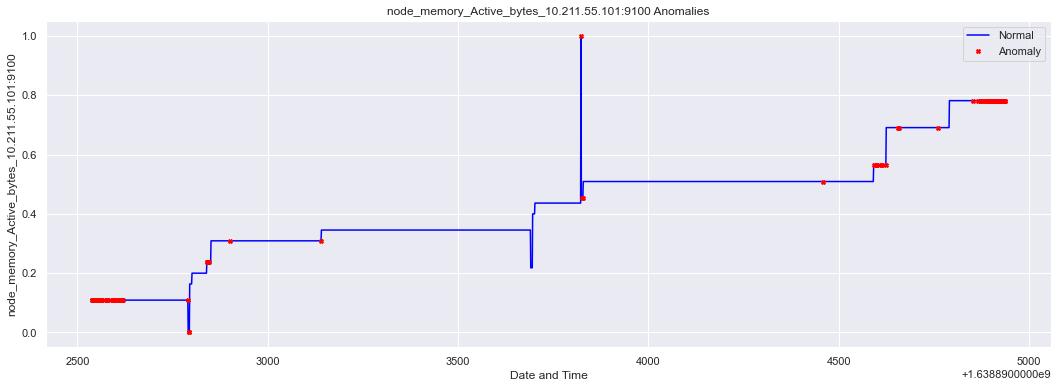

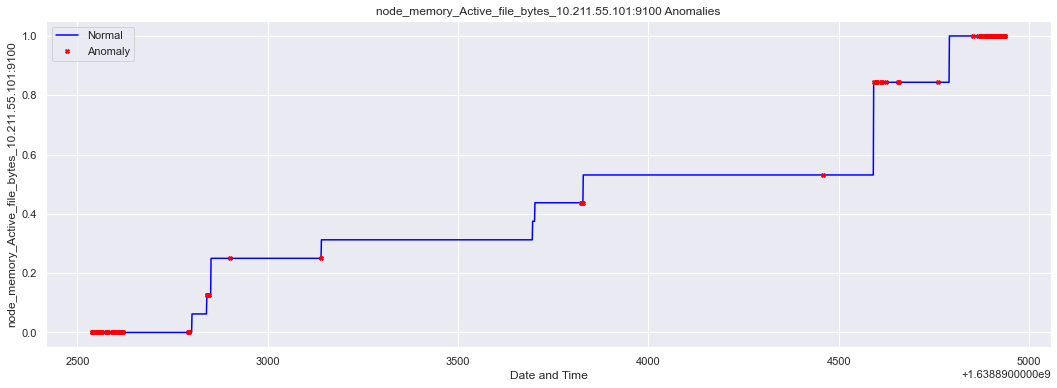

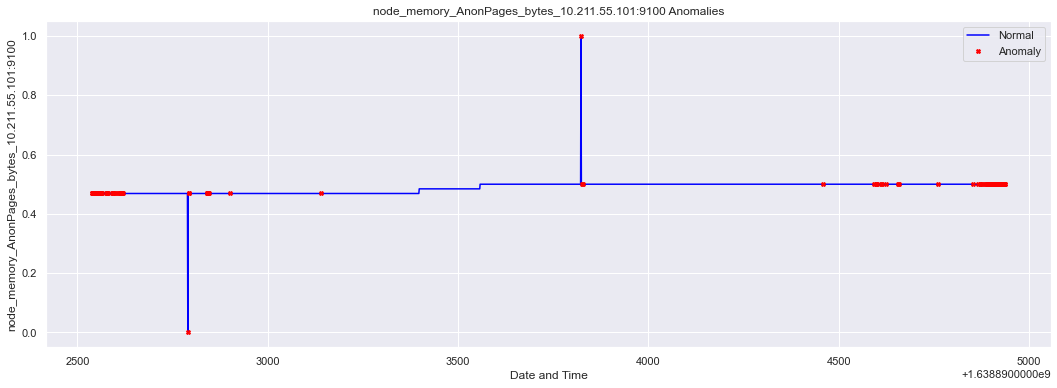

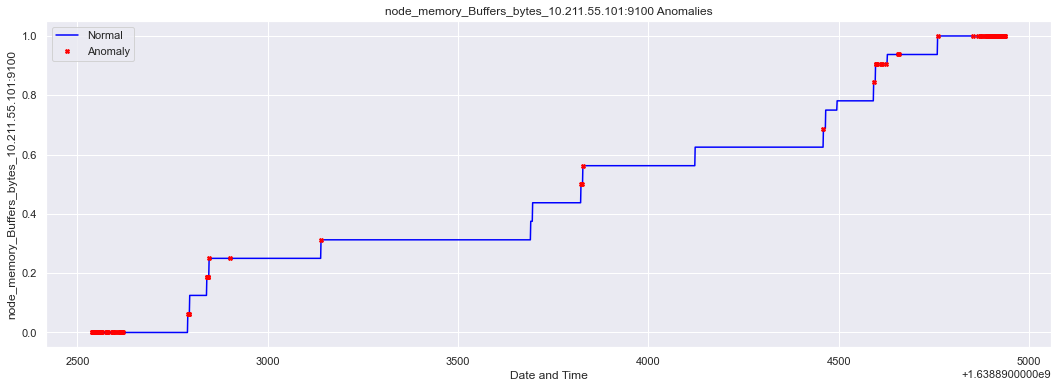

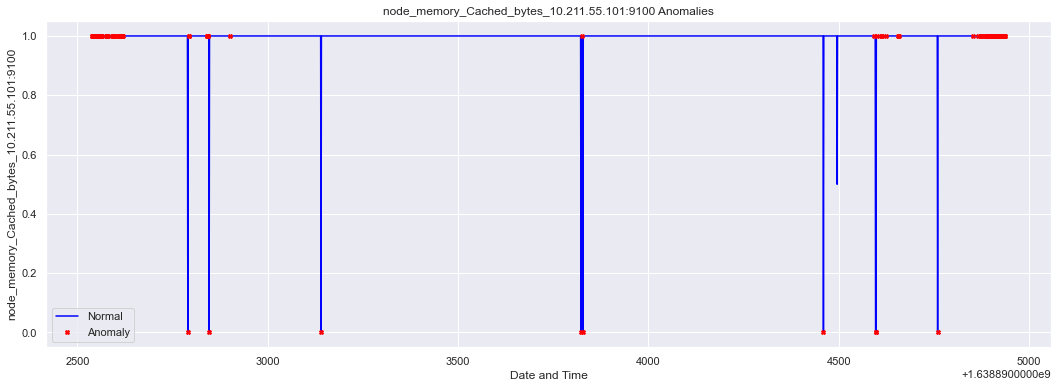

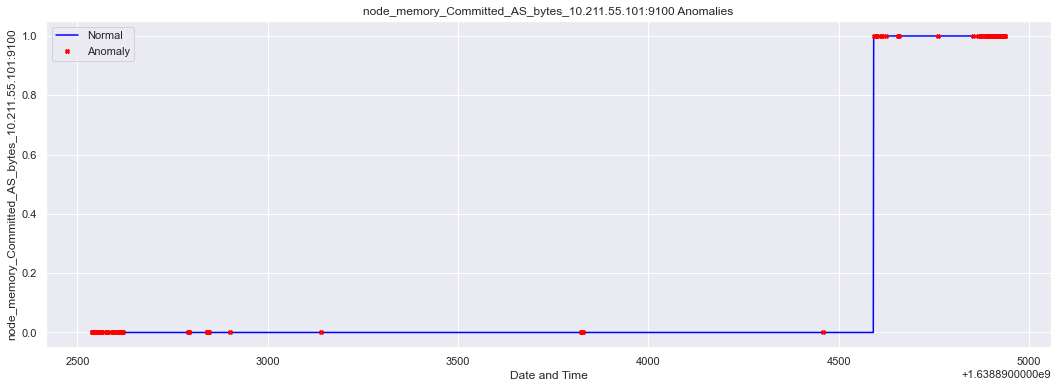

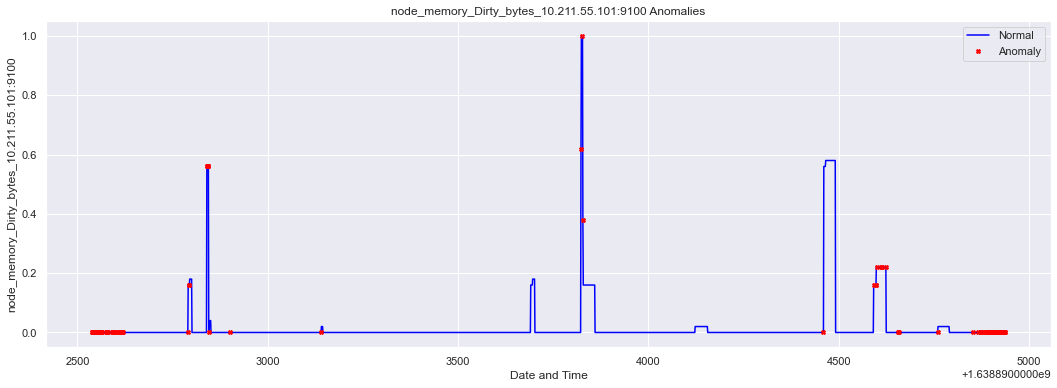

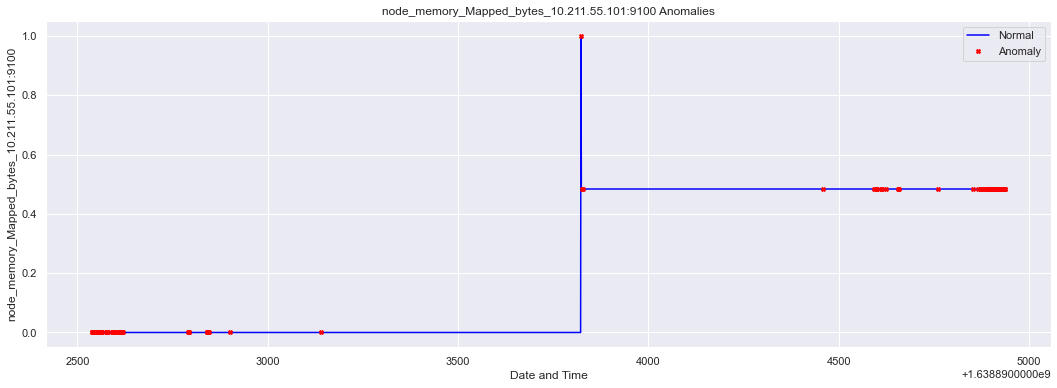

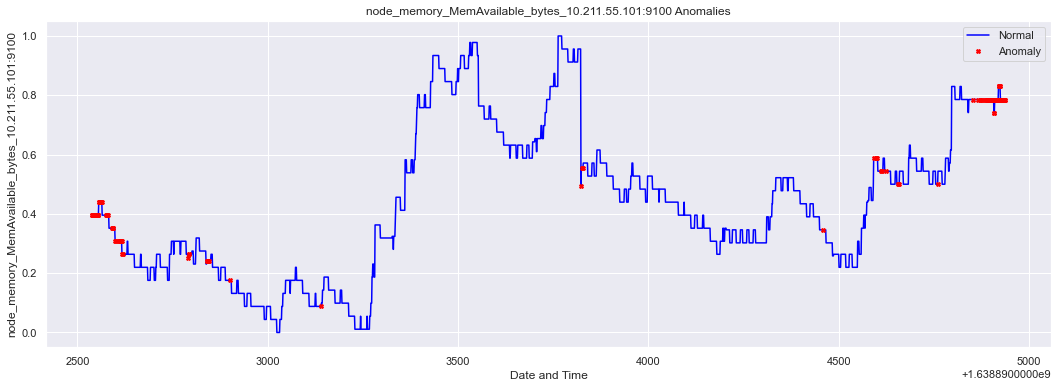

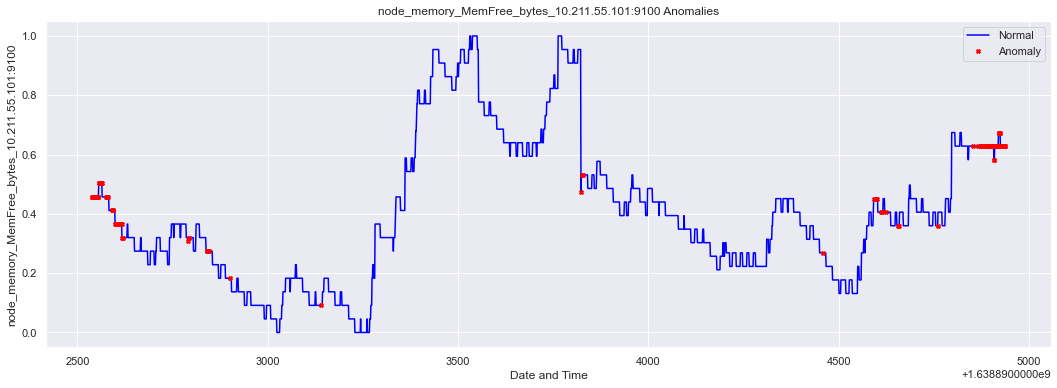

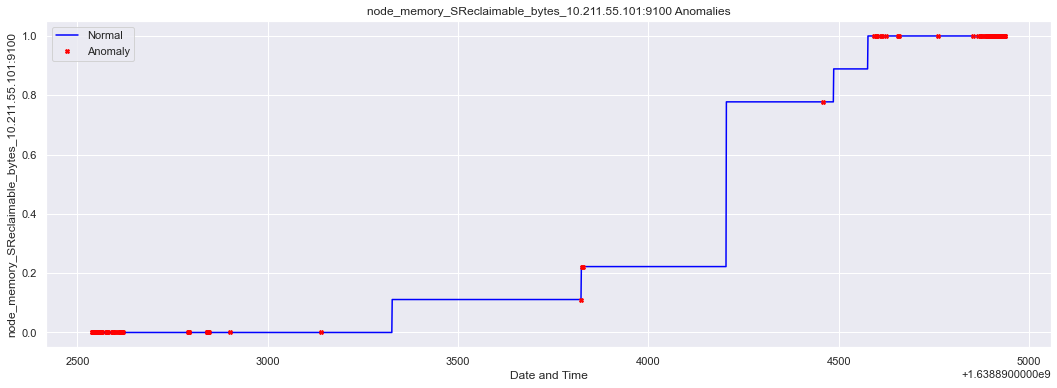

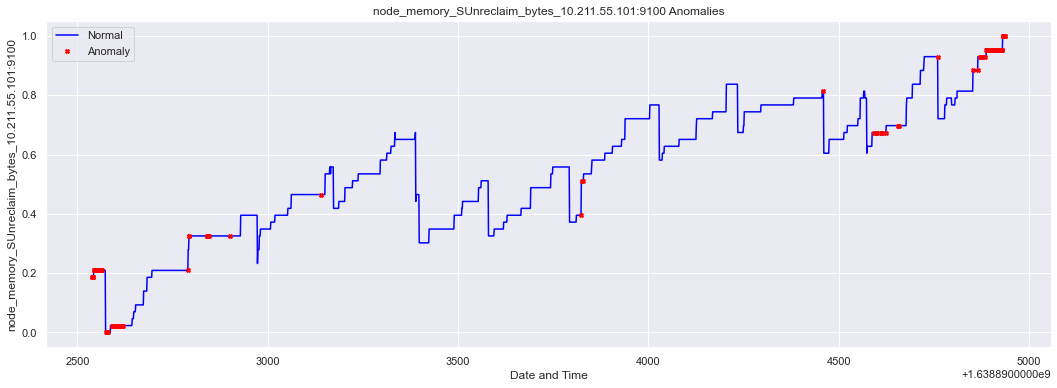

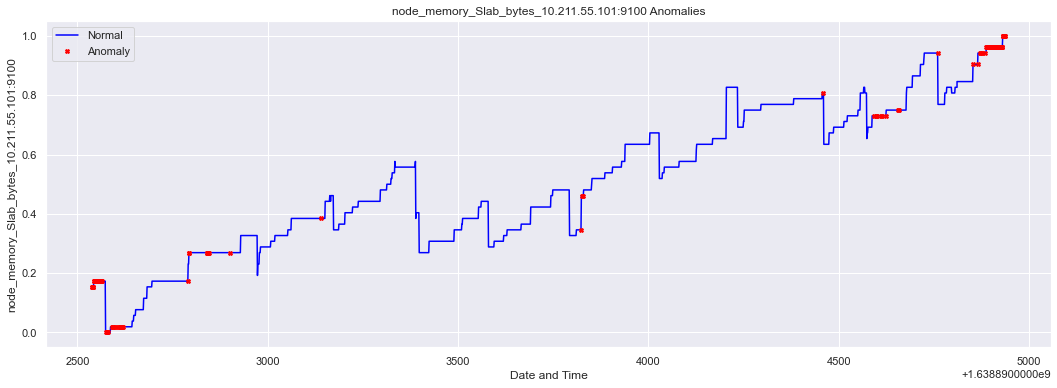

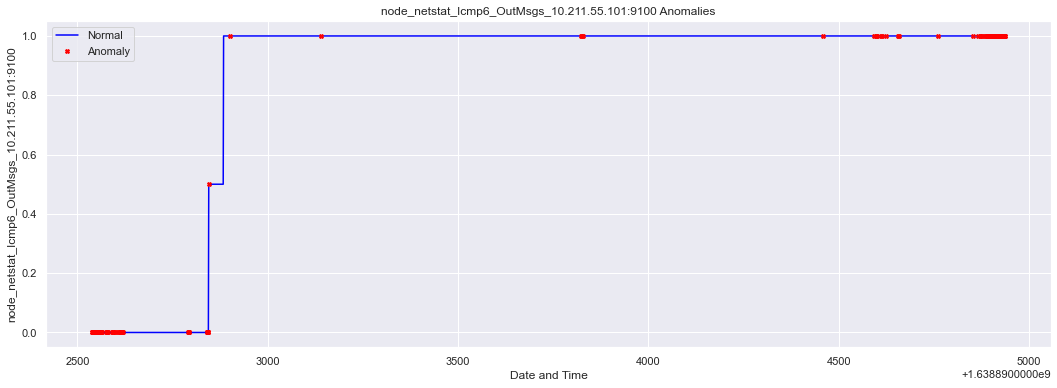

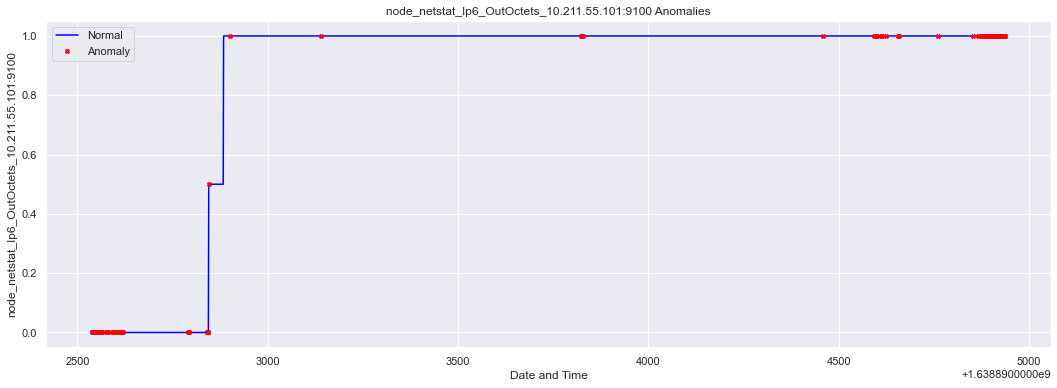

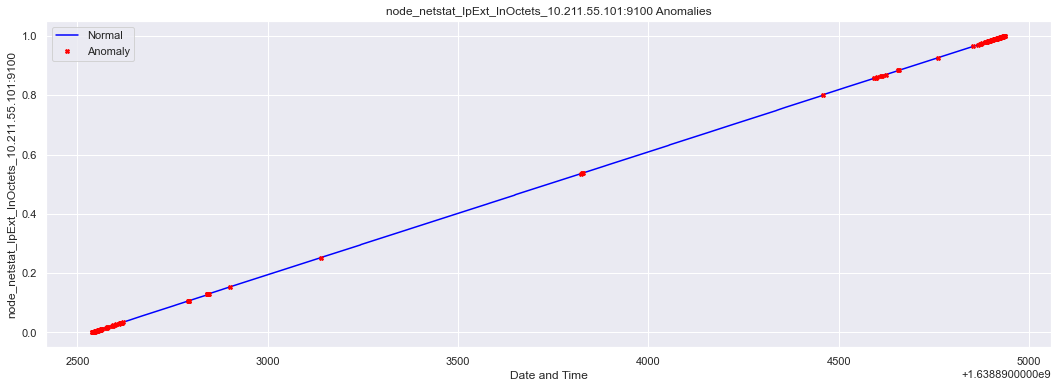

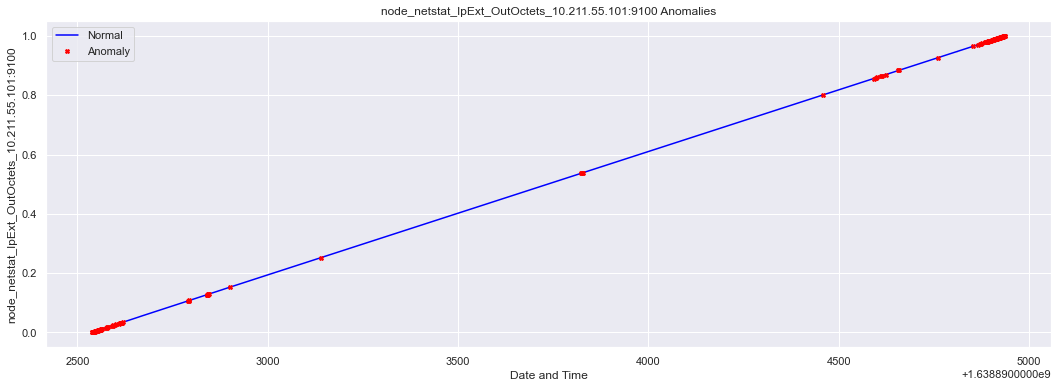

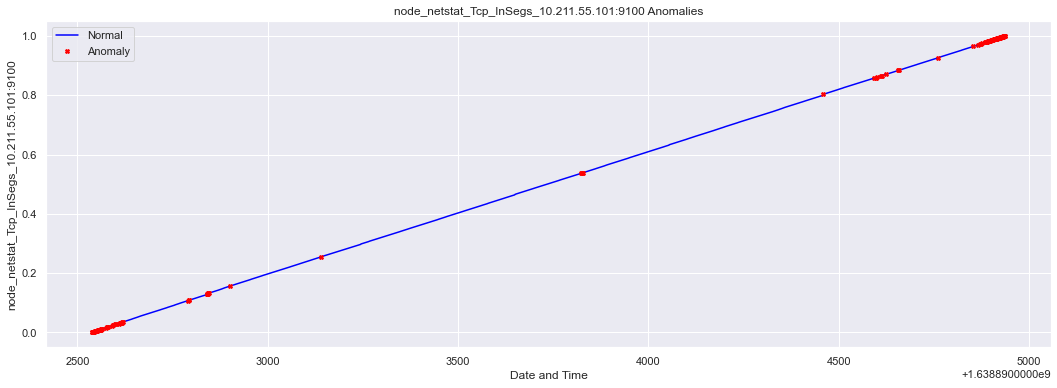

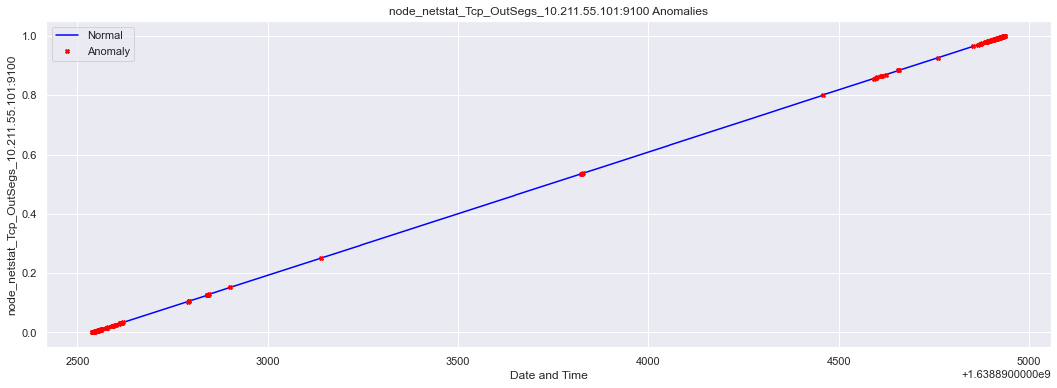

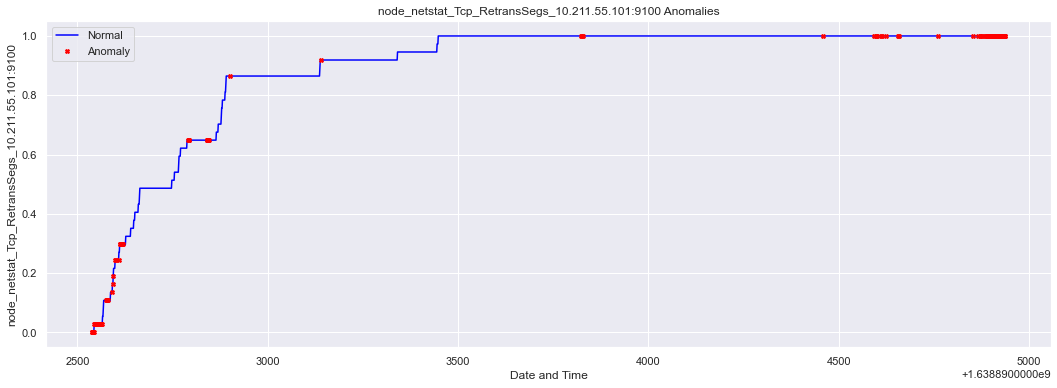

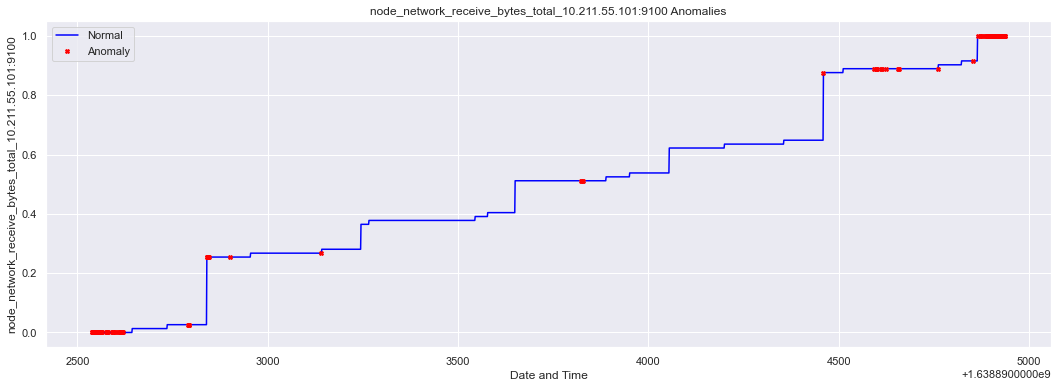

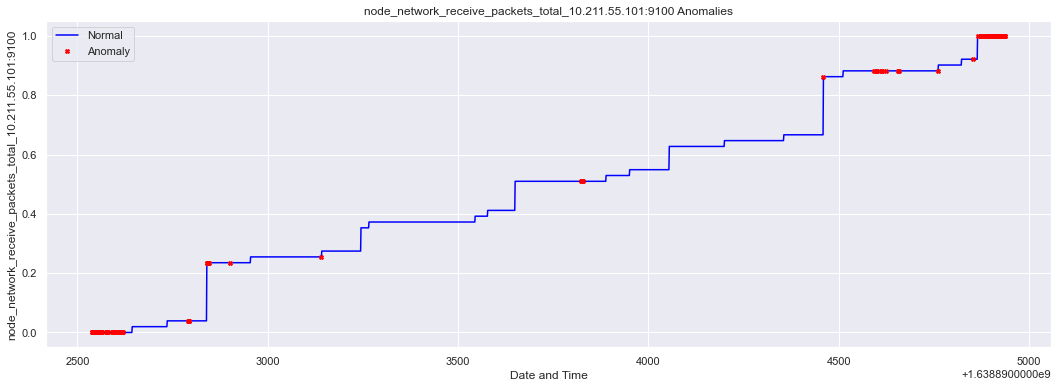

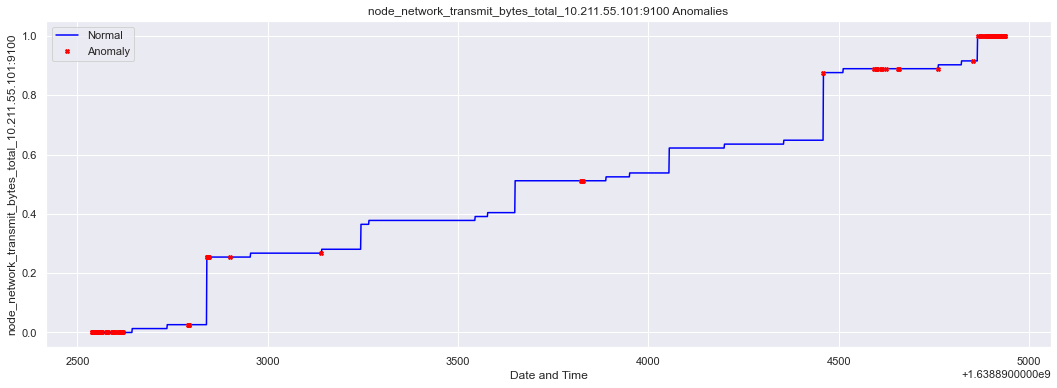

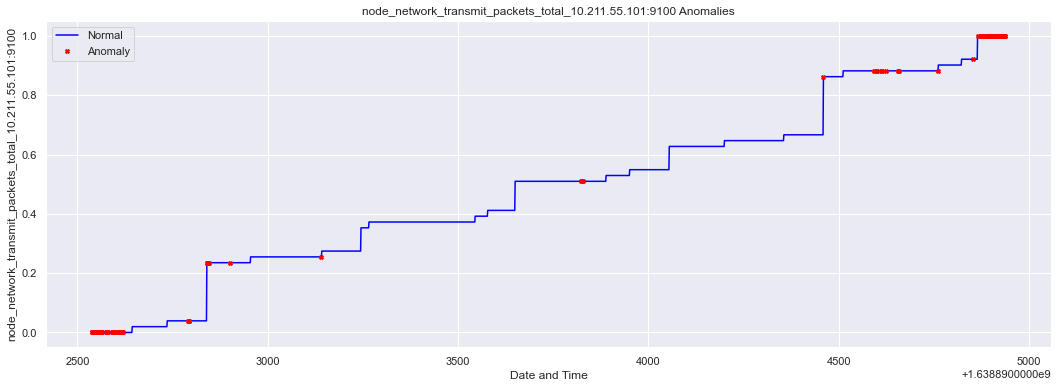

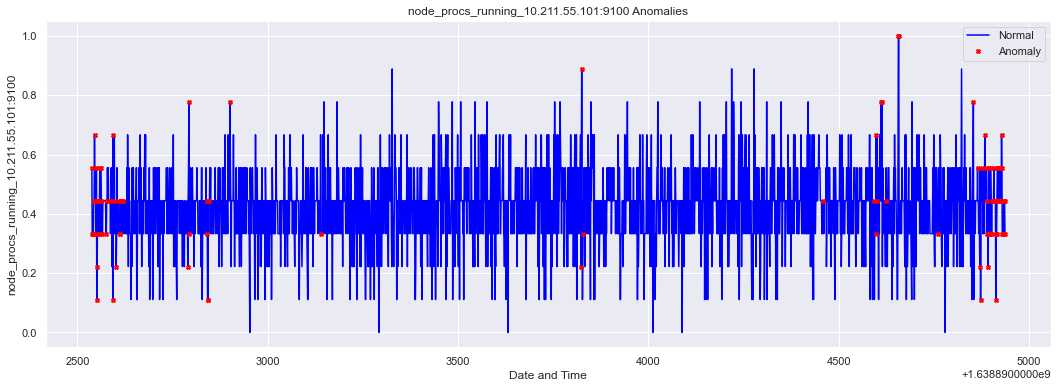

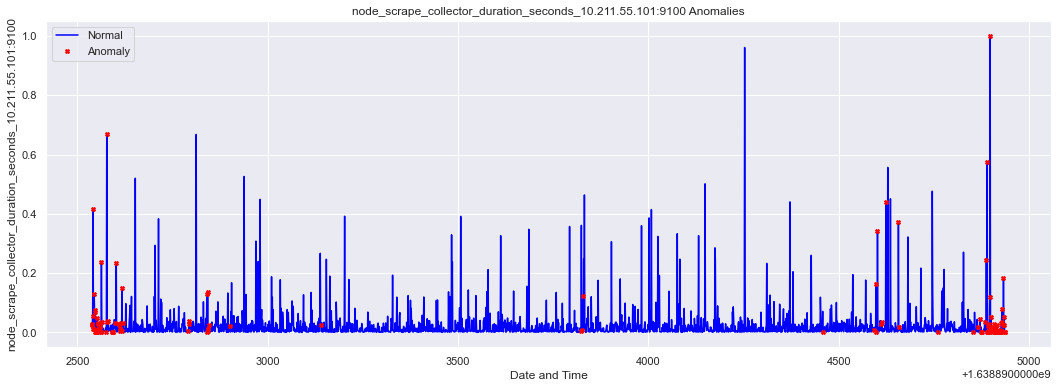

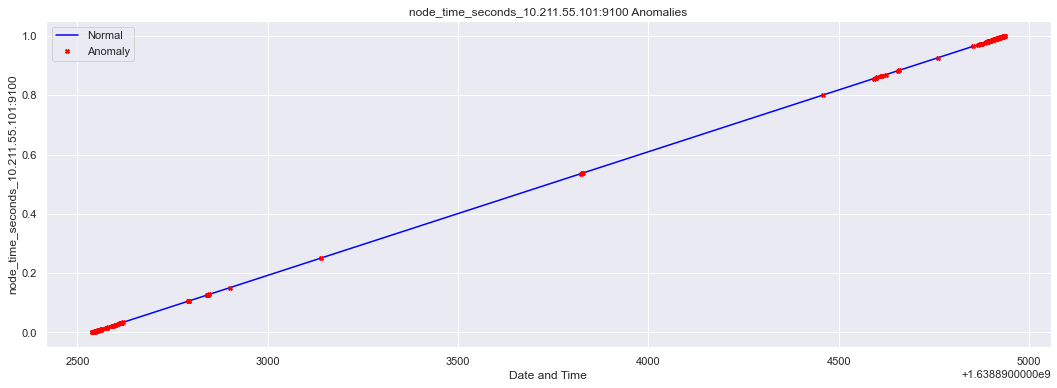

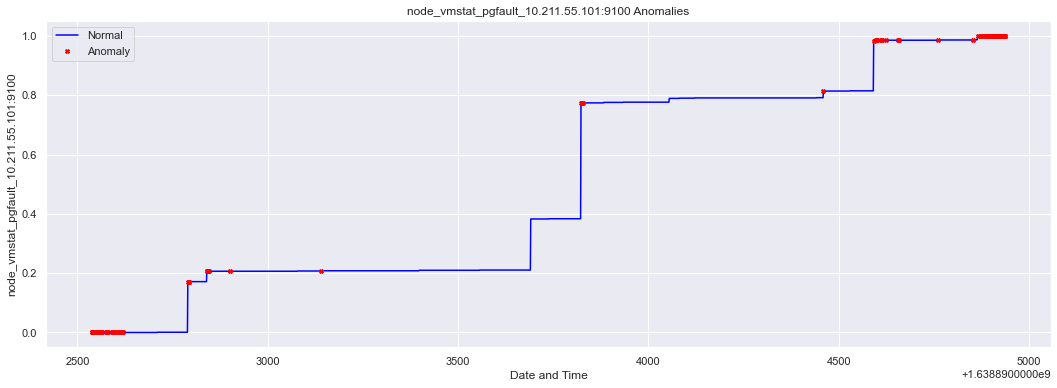

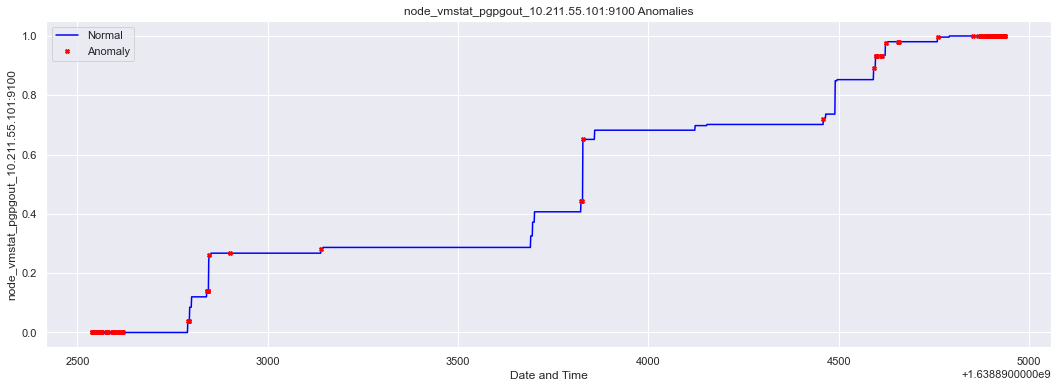

In [62]:
col_names_plt = list(df_plot.columns.values)
df_plot['anomaly'] = pred

for feature in col_names_plt:
    if feature == 'epoch' or feature == 'anomaly':
        pass
    else:
        # fig, ax = plt.subplots(figsize=(15,10))
        a = df_plot[df_plot['anomaly'] == -1] #anomaly
        _ = plt.figure(figsize=(18,6))
        _ = plt.plot(df_plot[feature], color='blue', label='Normal')
        _ = plt.plot(a[feature], linestyle='none', marker='X', color='red', markersize=4, label='Anomaly')
        _ = plt.xlabel('Date and Time')
        _ = plt.ylabel(f'{feature}')
        _ = plt.title(f'{feature} Anomalies')
        _ = plt.legend(loc='best')
        plt.show();

In [64]:
prometheus_endpoint = '10.9.8.136'
prometheus_port = '9090'
print("Collecting data from Monitoring at: {}".format(prometheus_endpoint))
#https://prometheus.io/docs/prometheus/latest/querying/basics/
prometheus_query = {"query": '''{__name__=~"node.+"}[10m]'''}
try:
    url = '/api/v1/query'
    resp = requests.get('http://{}:{}{}'.format(prometheus_endpoint, prometheus_port, url), params=prometheus_query)
except Exception as inst:
    print("Error fetching data")

In [65]:
df_bd_lab = prtoDF(resp.json(), verbose=True, index='time')

100%|██████████| 401/401 [00:00<00:00, 1246.90it/s]

[INFO] PR query resulted in dataframe of size: (600, 194)
[WARN] PR query dataframe index set to  time


In [66]:
df_bd_lab.dropna(axis=1, inplace=True)
df_bd_lab_rm =  df_bd_lab.drop(rm_columns, axis=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_bd_lab_rm_scaled_np = scaler.fit_transform(df_bd_lab_rm)

In [67]:
df_bd_lab_rm_scaled = pd.DataFrame(df_bd_lab_rm_scaled_np, index=df_bd_lab_rm.index, columns=df_bd_lab_rm.columns)
df_bd_lab_rm_scaled

node_context_switches_total_10.211.55.101:9100  \
time                                                           
1.638896e+09                                        0.000000   
1.638896e+09                                        0.002401   
1.638896e+09                                        0.004200   
1.638896e+09                                        0.006272   
1.638896e+09                                        0.007846   
...                                                      ...   
1.638897e+09                                        0.994074   
1.638897e+09                                        0.995058   
1.638897e+09                                        0.996311   
1.638897e+09                                        0.998071   
1.638897e+09                                        1.000000   

              node_cpu_seconds_total_10.211.55.101:9100  \
time                                                      
1.638896e+09                                   0.000000   
1.638896e+09                                   0.003077   
1.638896e+09                                   0.006154   
1.638896e+09                                   0.006154   
1.638896e+09                                   0.006154   
...                                                 ...   
1.638897e+09                                   0.993846   
1.638897e+09                                   0.993846   
1.638897e+09                                   0.996923   
1.638897e+09                                   1.000000   
1.638897e+09                                   1.000000   

              node_entropy_available_bits_10.211.55.101:9100  \
time                                                           
1.638896e+09                                        0.344697   
1.638896e+09                                        0.348485   
1.638896e+09                                        0.352273   
1.638896e+09                                        0.352273   
1.638896e+09                                        0.356061   
...                                                      ...   
1.638897e+09                                        0.151515   
1.638897e+09                                        0.155303   
1.638897e+09                                        0.159091   
1.638897e+09                                        0.162879   
1.638897e+09                                        0.166667   

              node_filefd_allocated_10.211.55.101:9100  \
time                                                     
1.638896e+09                                       0.0   
1.638896e+09                                       0.0   
1.638896e+09                                       0.0   
1.638896e+09                                       0.0   
1.638896e+09                                       0.0   
...                                                ...   
1.638897e+09                                       1.0   
1.638897e+09                                       1.0   
1.638897e+09                                       1.0   
1.638897e+09                                       1.0   
1.638897e+09                                       1.0   

              node_filesystem_avail_bytes_10.211.55.101:9100  \
time                                                           
1.638896e+09                                             1.0   
1.638896e+09                                             1.0   
1.638896e+09                                             1.0   
1.638896e+09                                             1.0   
1.638896e+09                                             1.0   
...                                                      ...   
1.638897e+09                                             0.0   
1.638897e+09                                             0.0   
1.638897e+09                                             0.0   
1.638897e+09                                             0.0   
1.638897e+09                                             

In [68]:
pred_2 = clf.predict(df_bd_lab_rm_scaled)

In [71]:
list(pred_2).count(-1)

502

['node_context_switches_total_10.211.55.101:9100'
 'node_cpu_seconds_total_10.211.55.101:9100'
 'node_entropy_available_bits_10.211.55.101:9100'
 'node_filefd_allocated_10.211.55.101:9100'
 'node_filesystem_avail_bytes_10.211.55.101:9100'
 'node_filesystem_free_bytes_10.211.55.101:9100'
 'node_forks_total_10.211.55.101:9100'
 'node_intr_total_10.211.55.101:9100' 'node_load1_10.211.55.101:9100'
 'node_load15_10.211.55.101:9100' 'node_load5_10.211.55.101:9100'
 'node_memory_Active_anon_bytes_10.211.55.101:9100'
 'node_memory_Active_bytes_10.211.55.101:9100'
 'node_memory_Active_file_bytes_10.211.55.101:9100'
 'node_memory_AnonPages_bytes_10.211.55.101:9100'
 'node_memory_Buffers_bytes_10.211.55.101:9100'
 'node_memory_Cached_bytes_10.211.55.101:9100'
 'node_memory_Committed_AS_bytes_10.211.55.101:9100'
 'node_memory_Dirty_bytes_10.211.55.101:9100'
 'node_memory_Mapped_bytes_10.211.55.101:9100'
 'node_memory_MemAvailable_bytes_10.211.55.101:9100'
 'node_memory_MemFree_bytes_10.211.55.101:

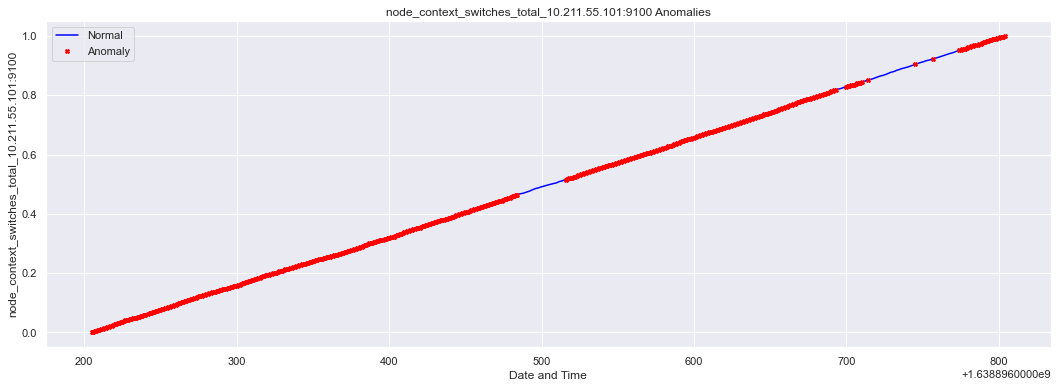

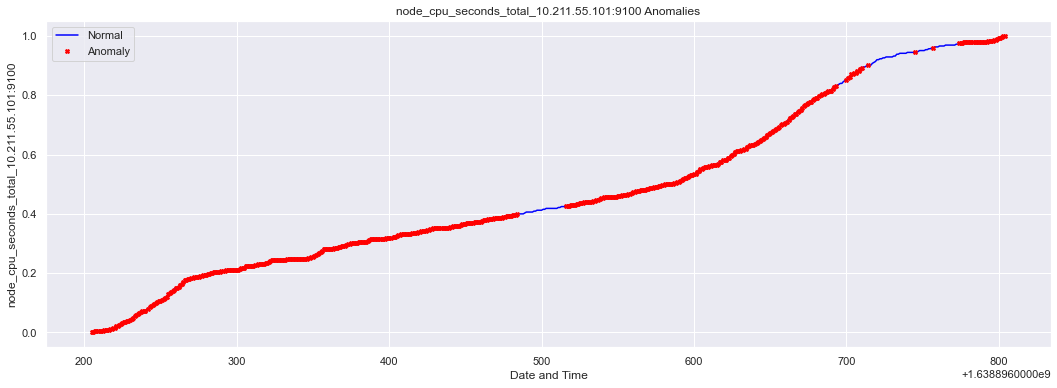

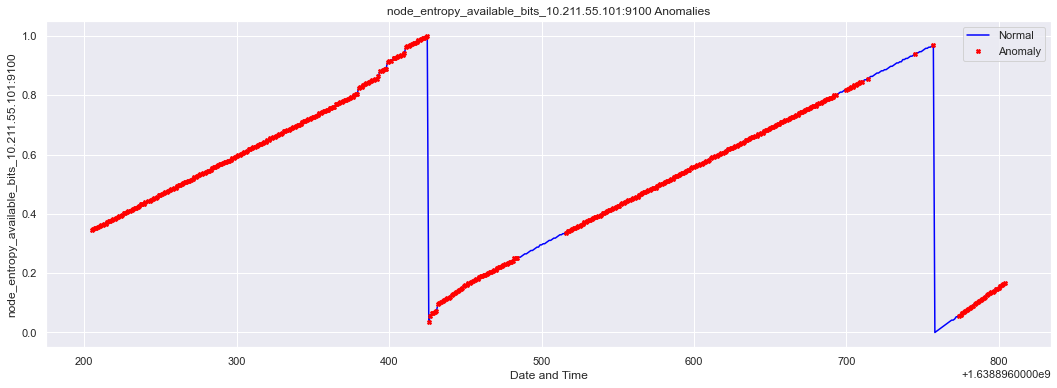

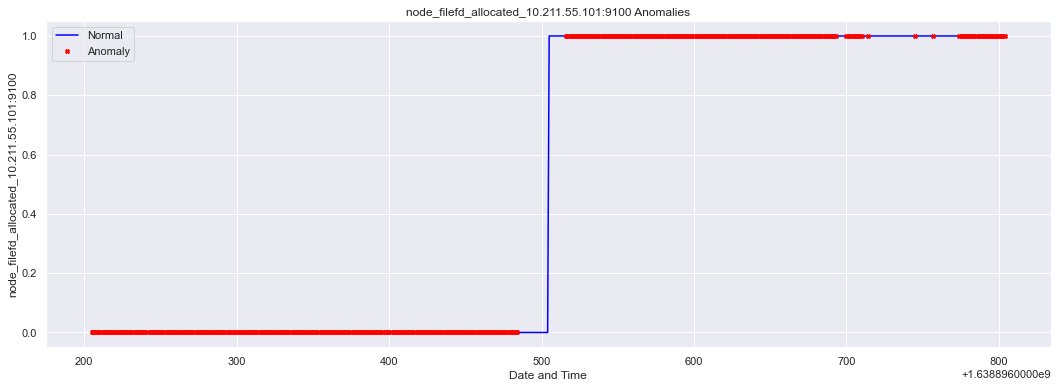

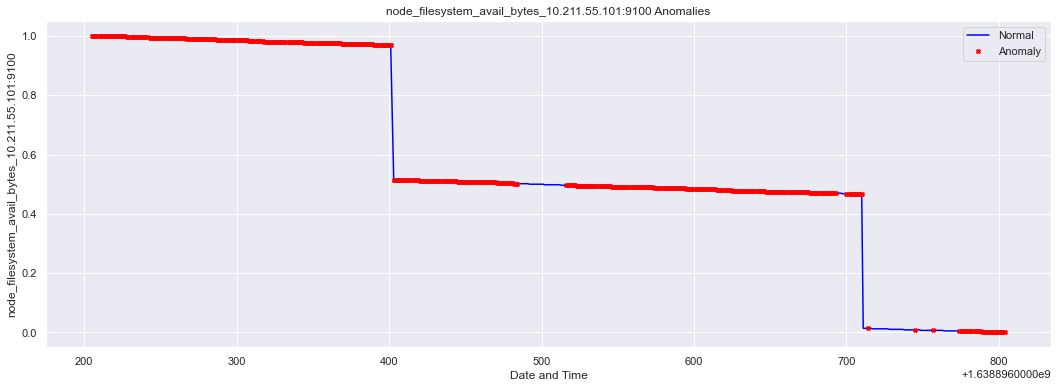

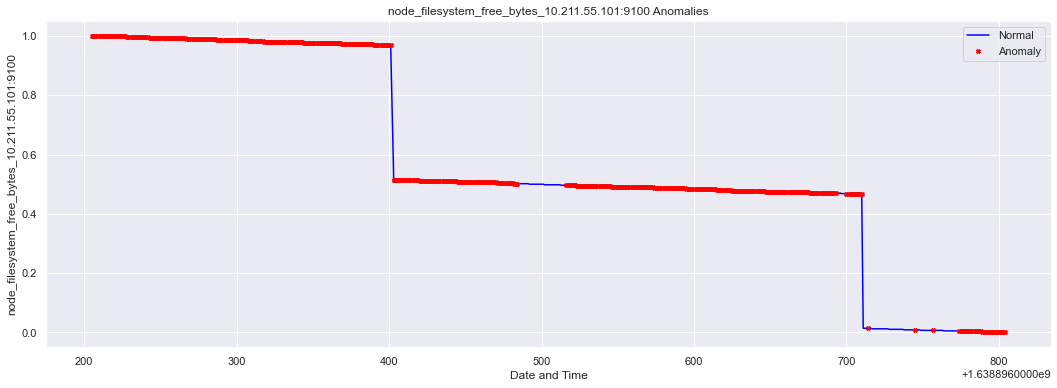

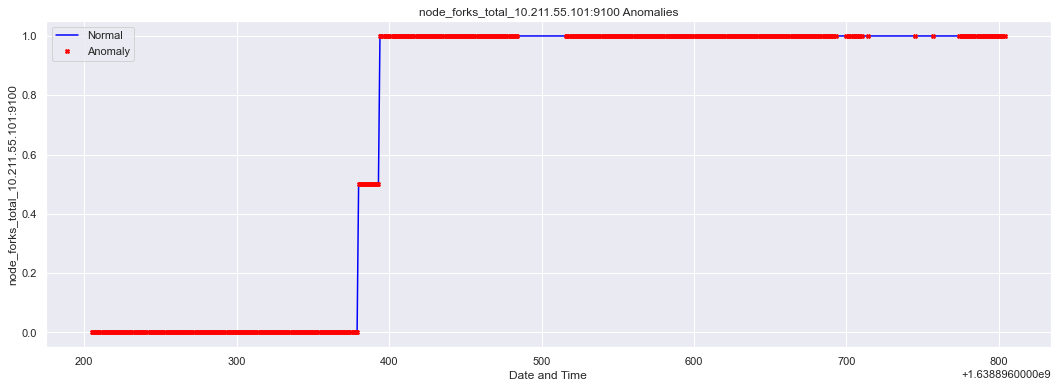

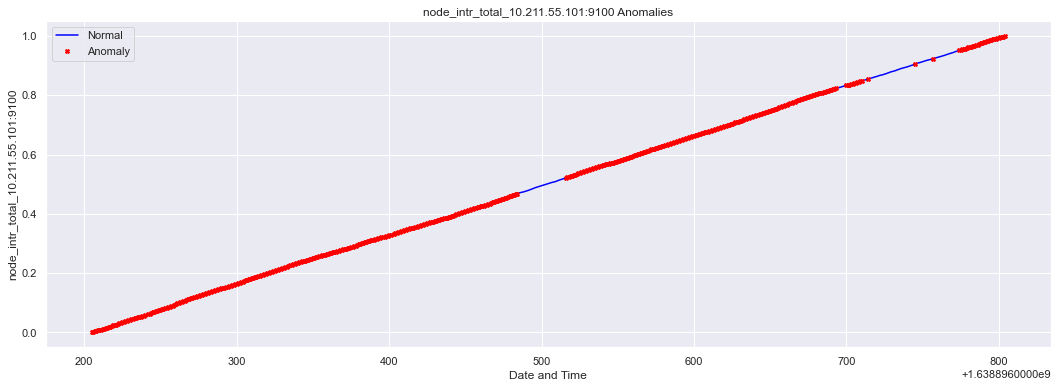

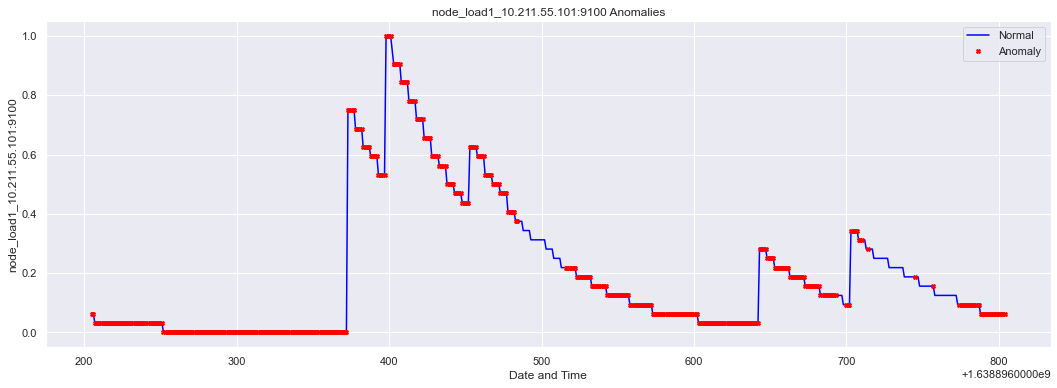

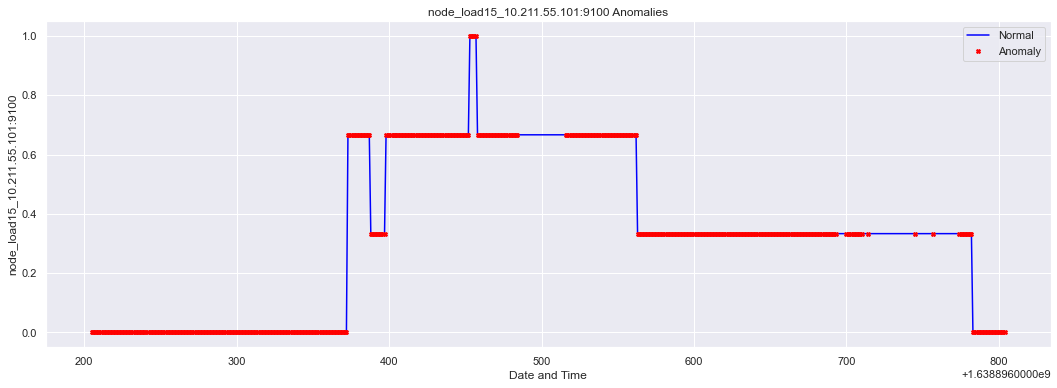

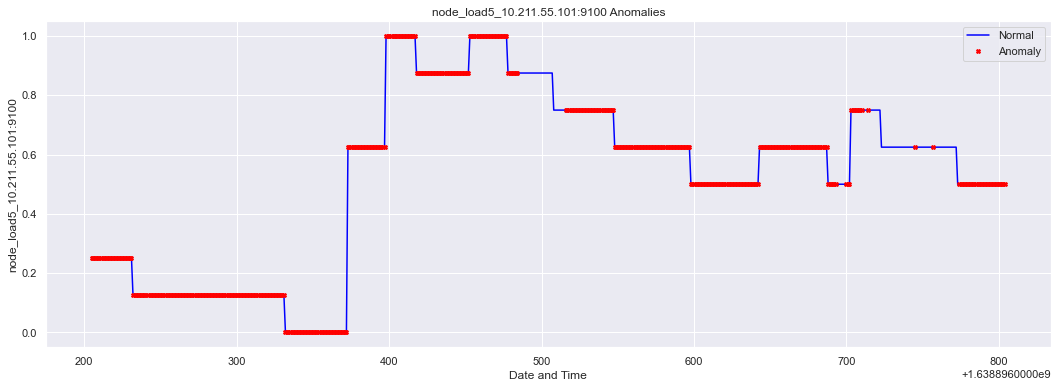

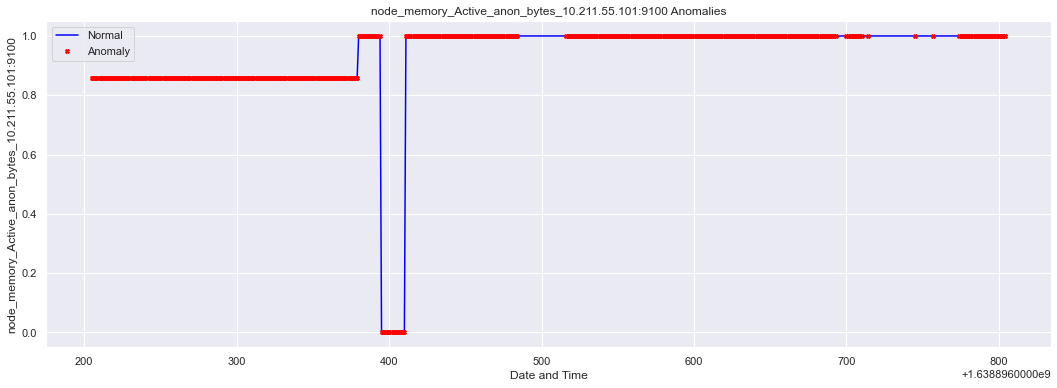

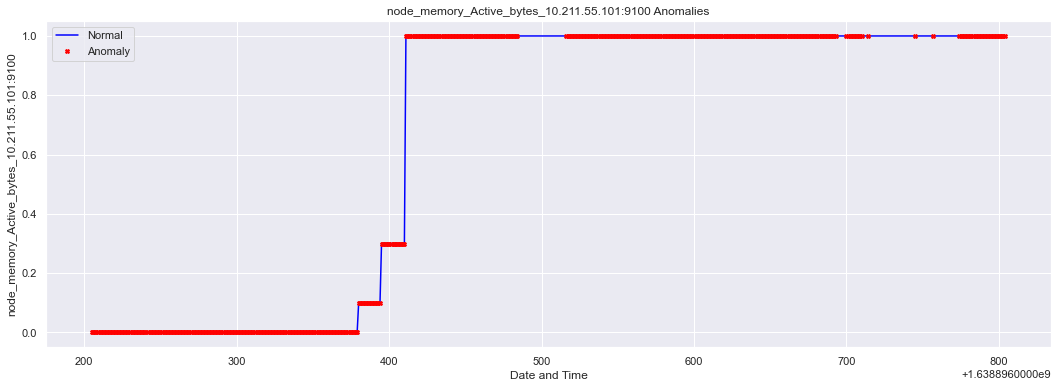

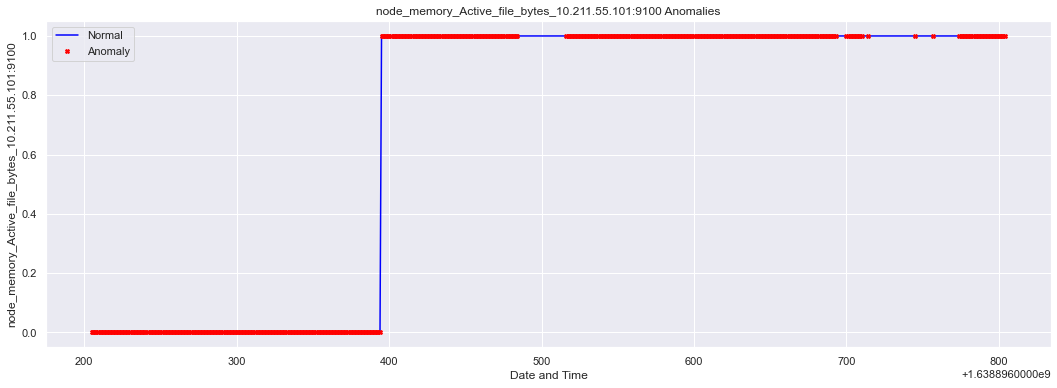

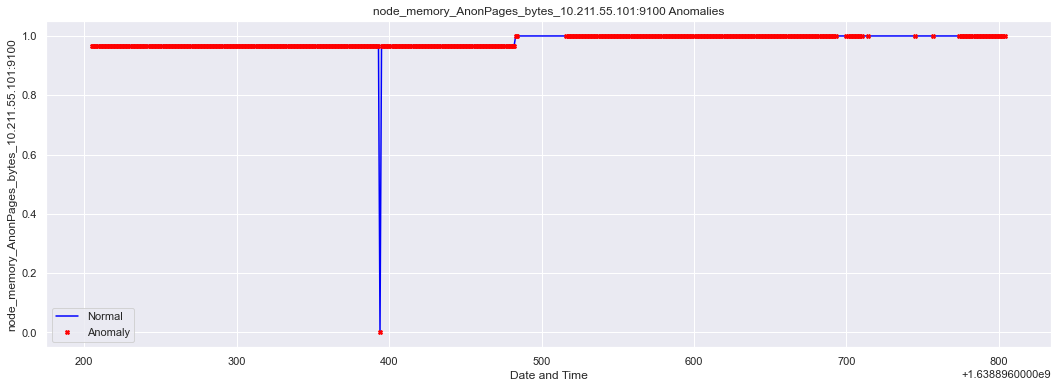

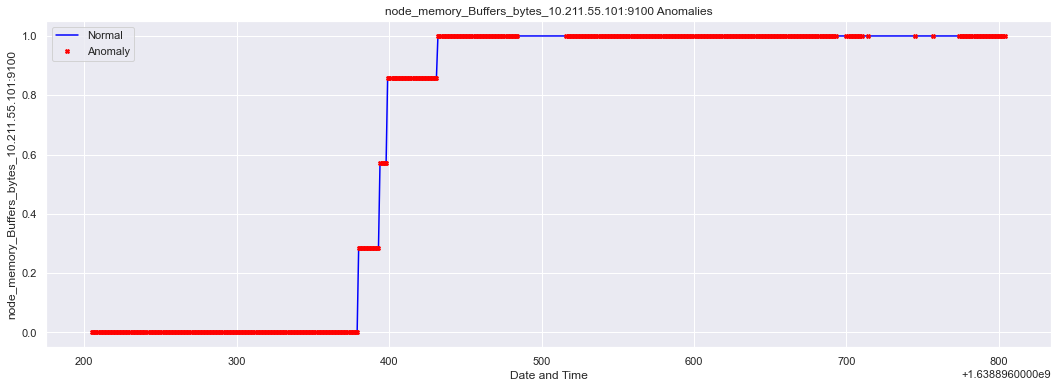

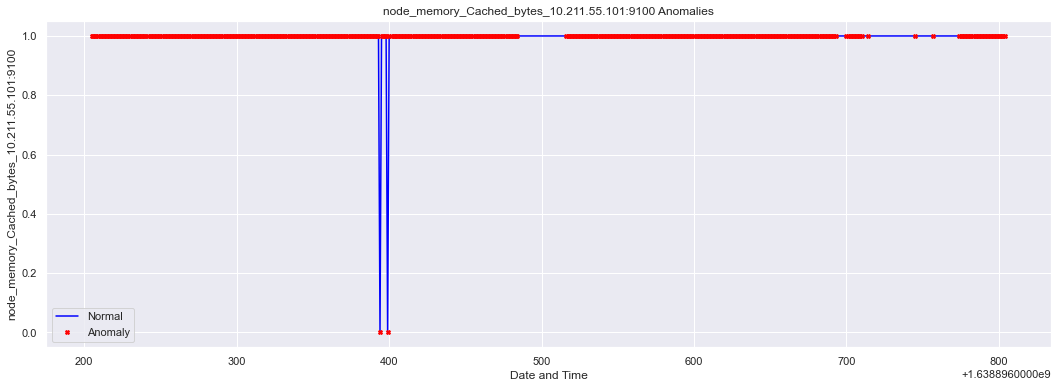

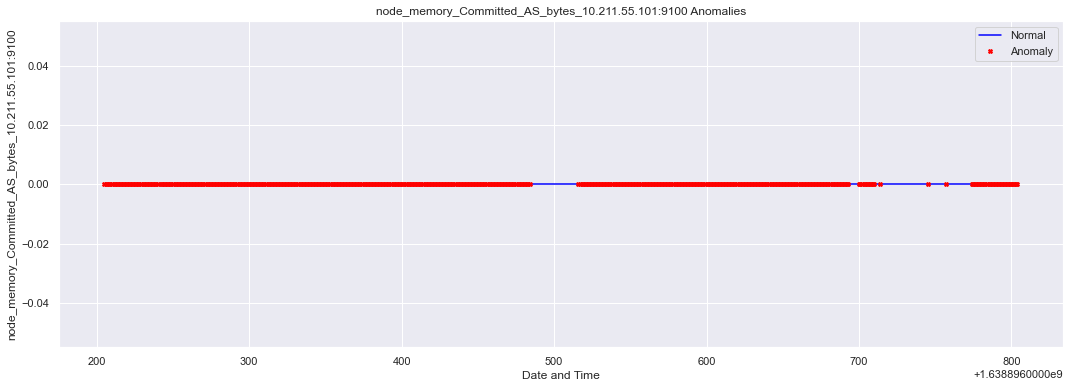

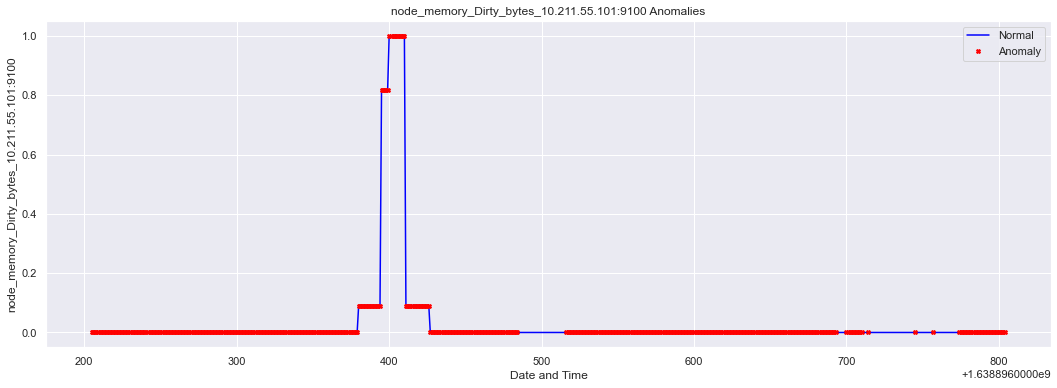

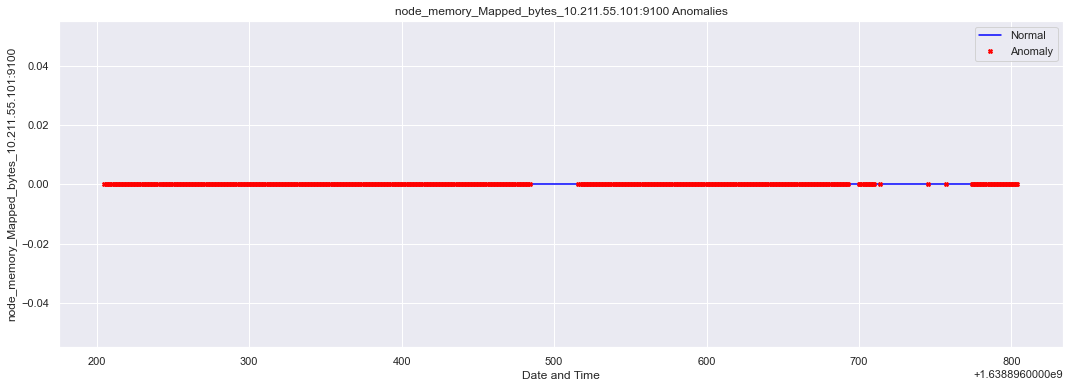

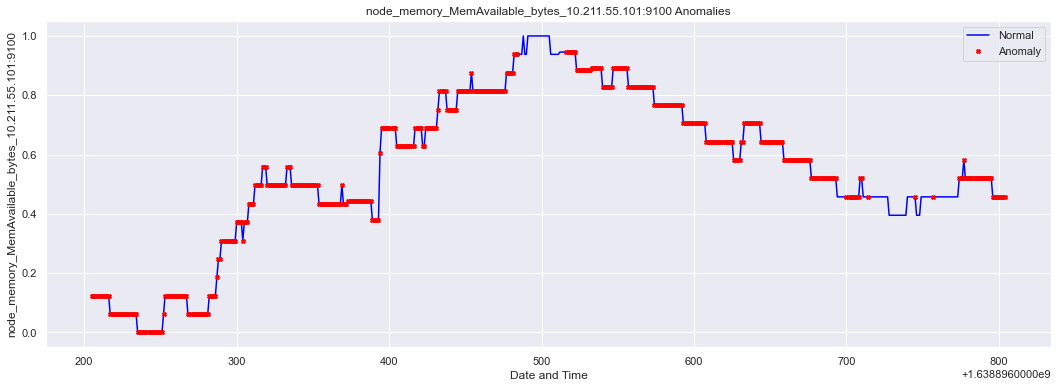

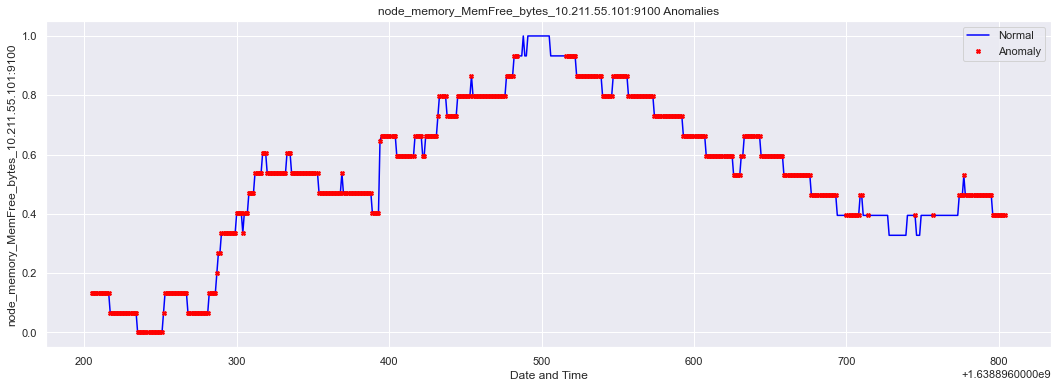

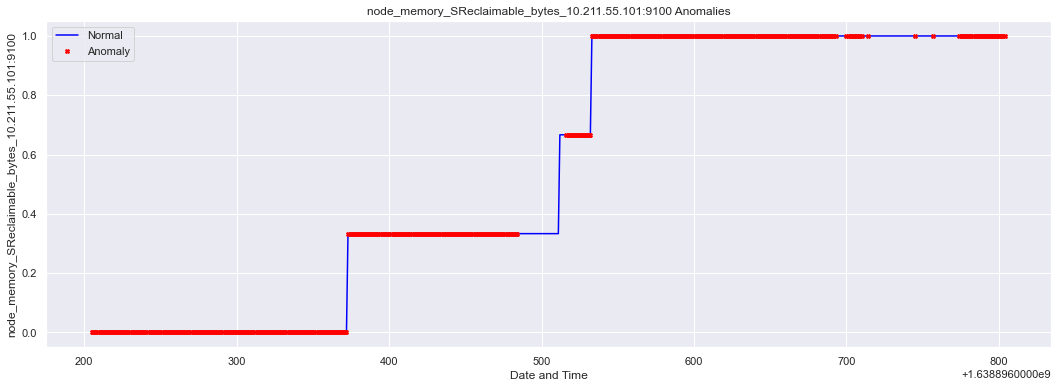

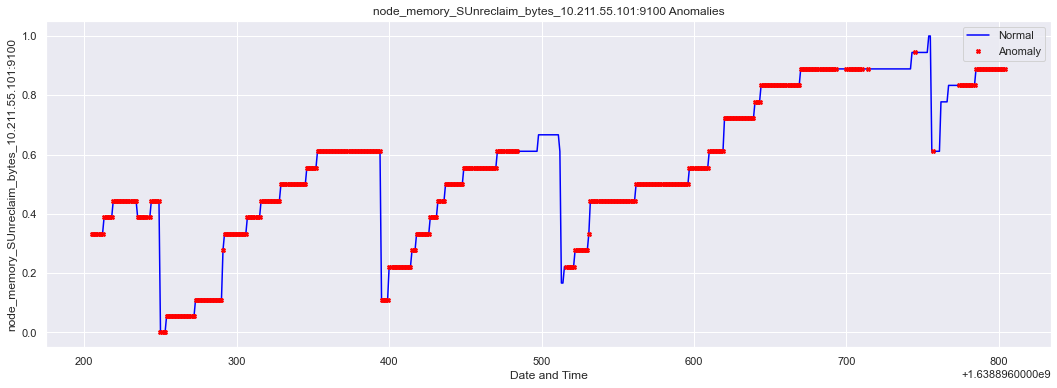

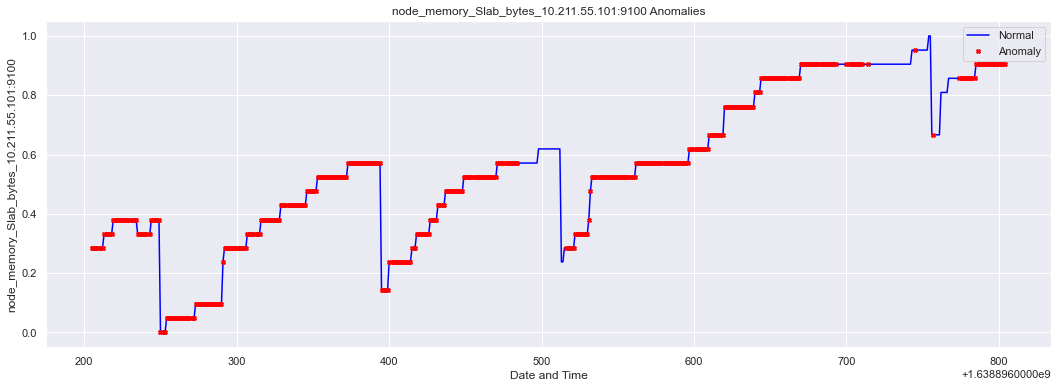

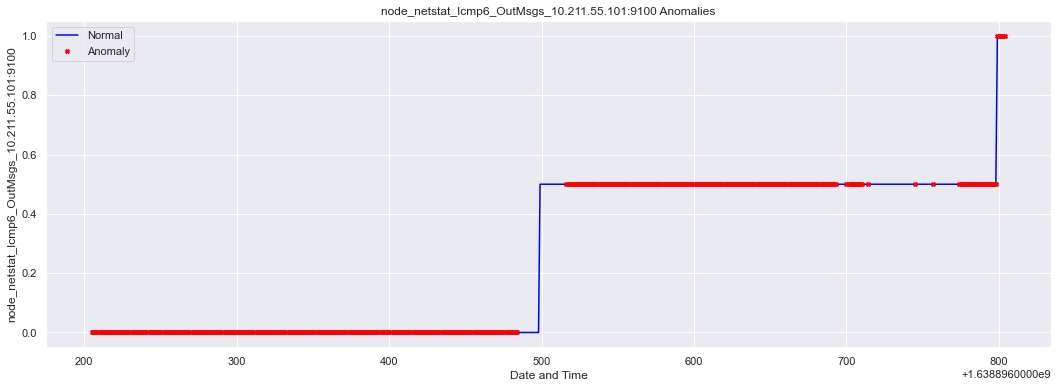

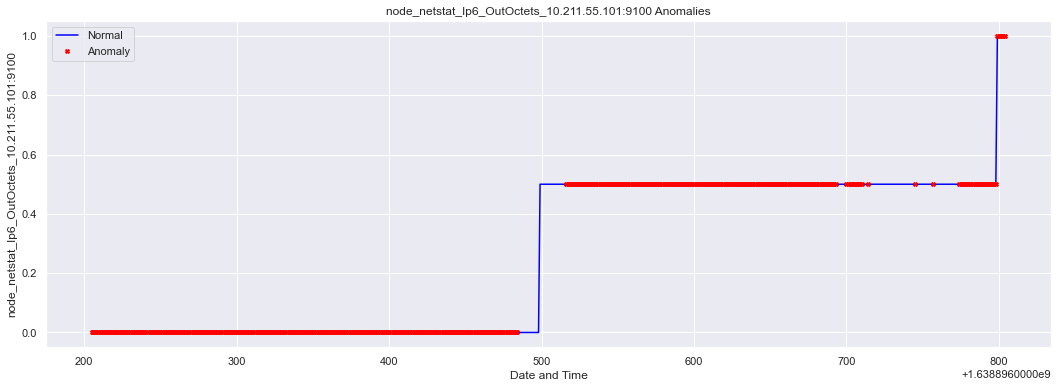

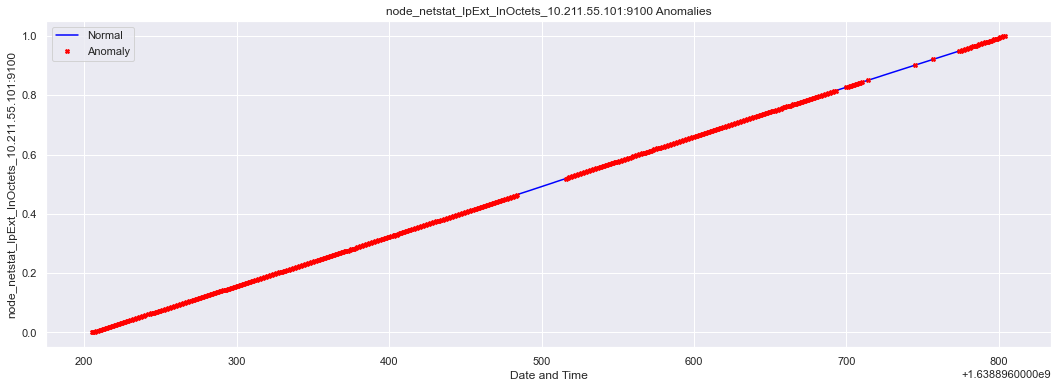

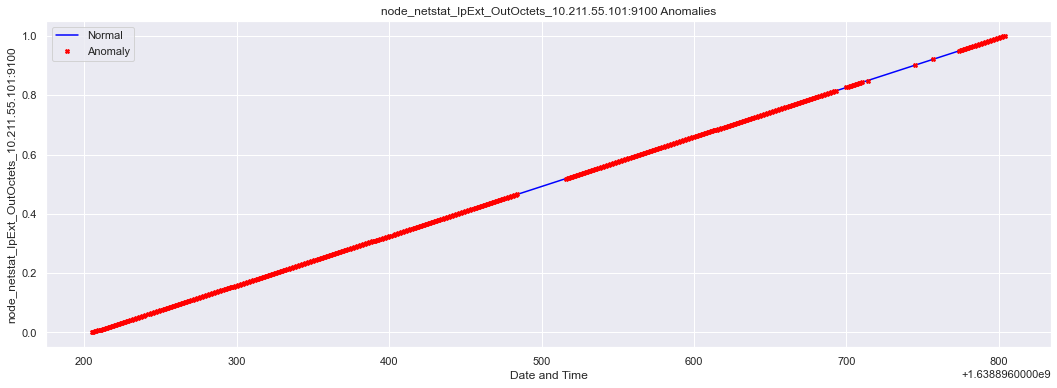

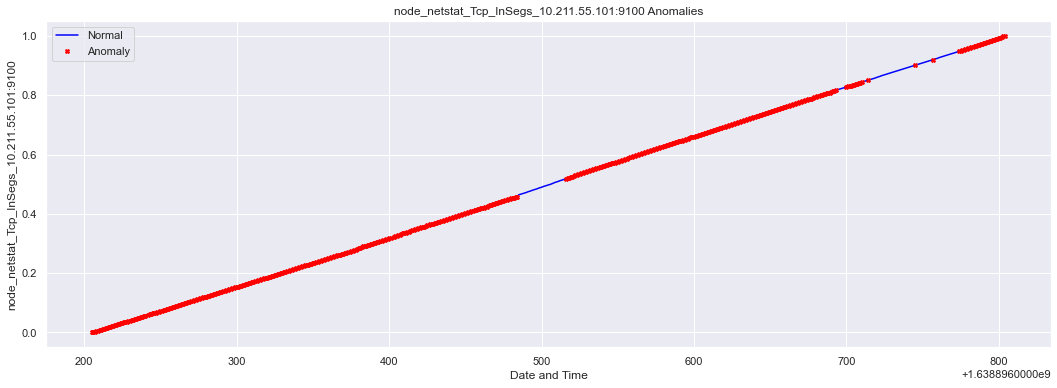

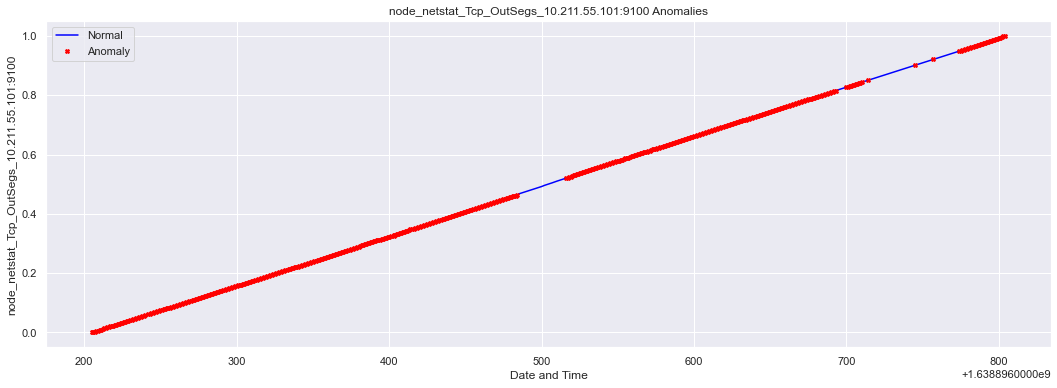

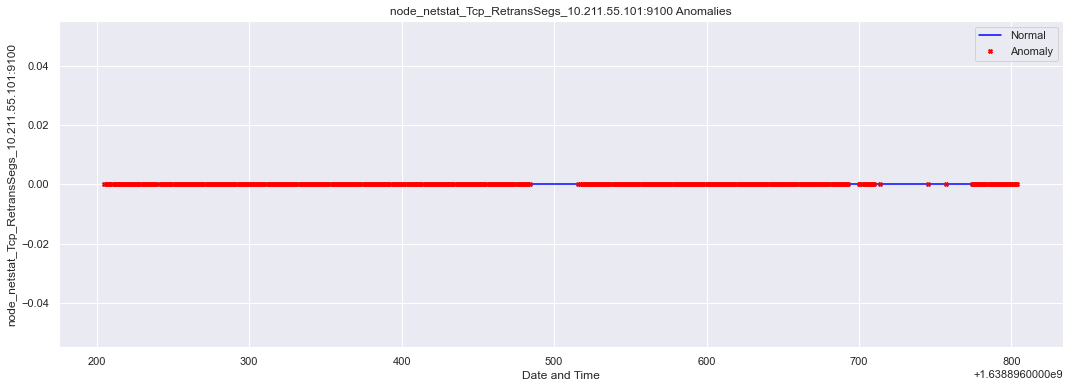

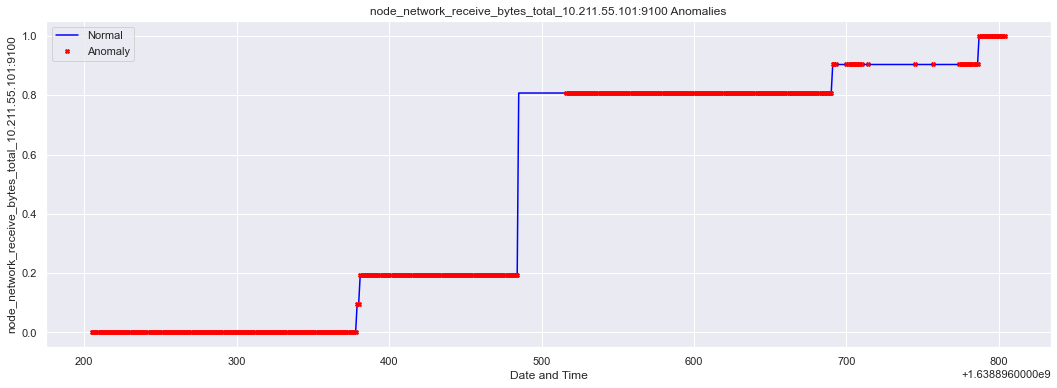

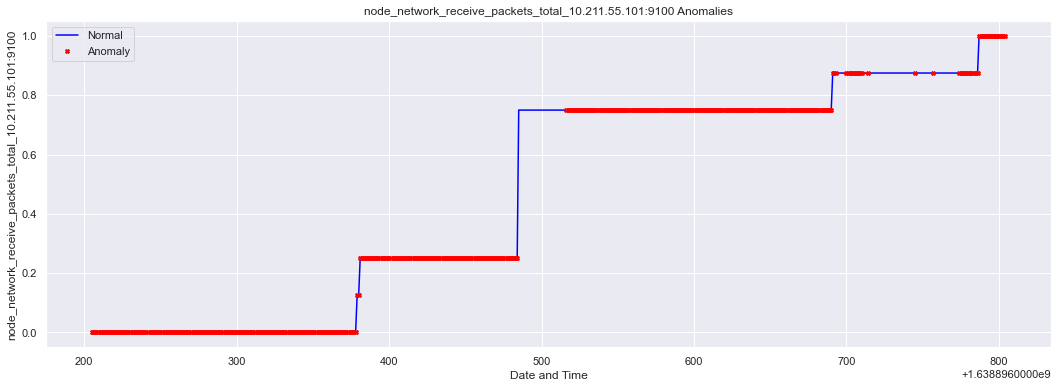

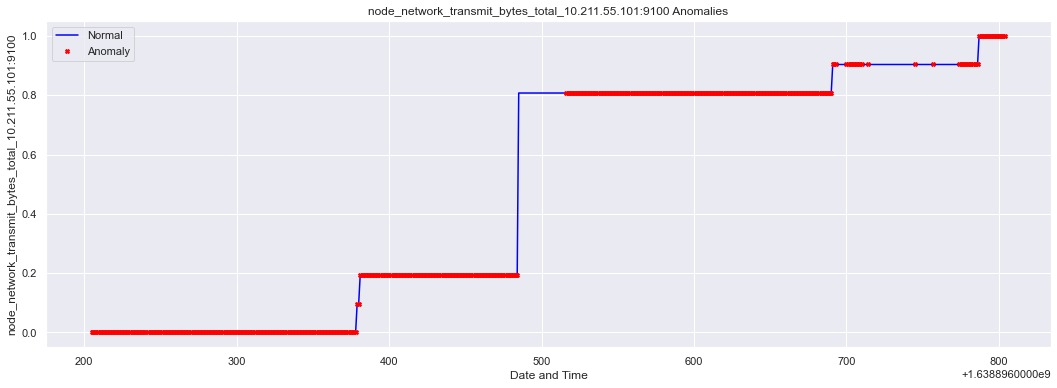

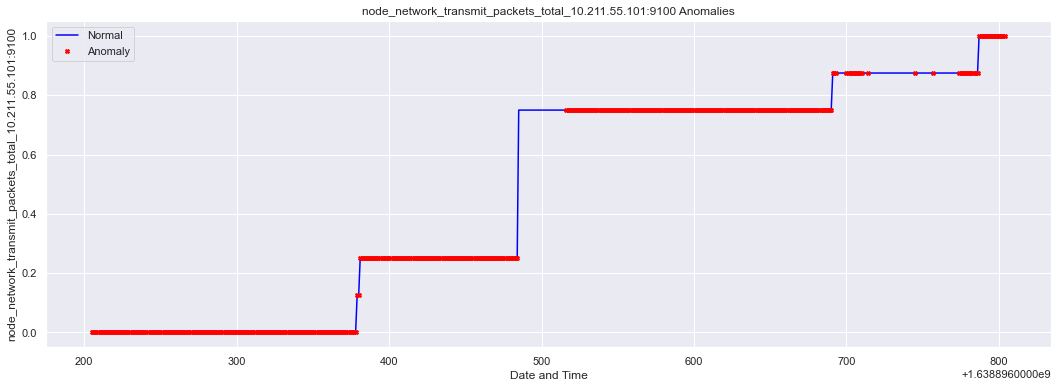

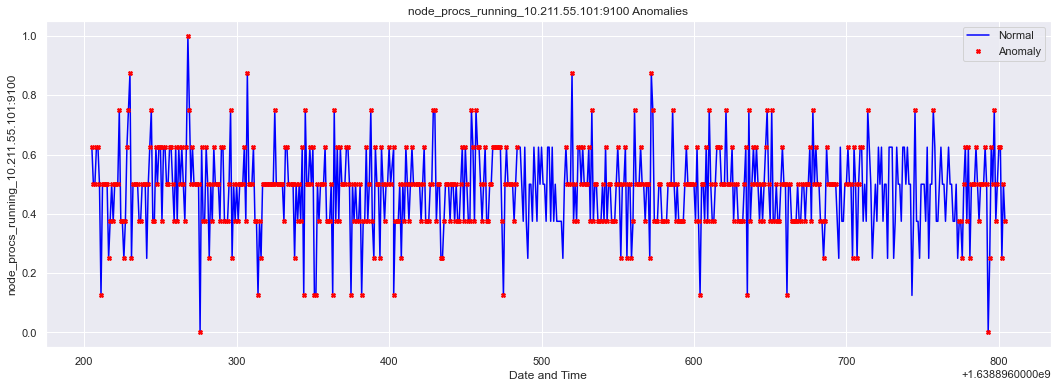

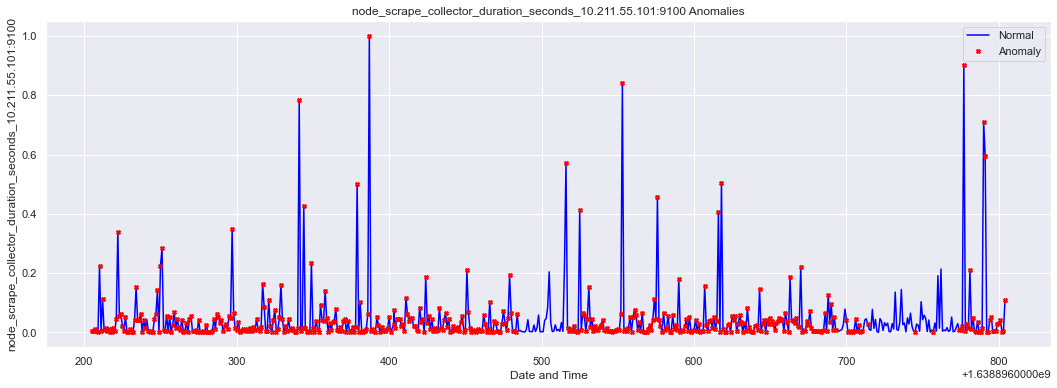

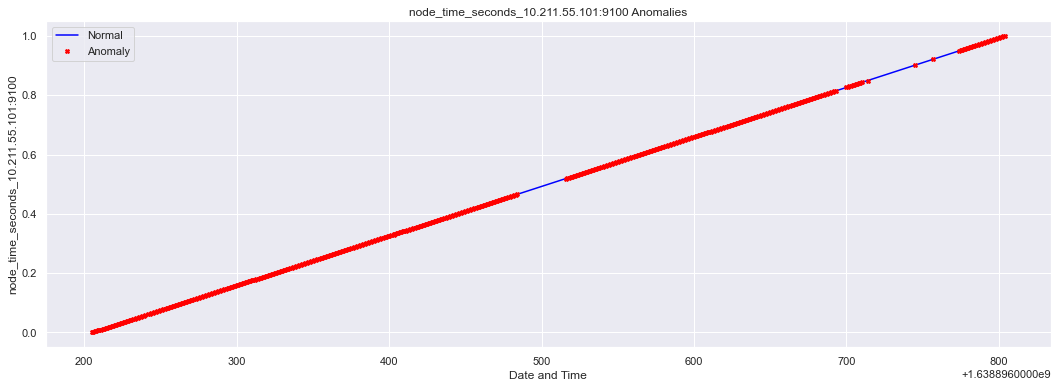

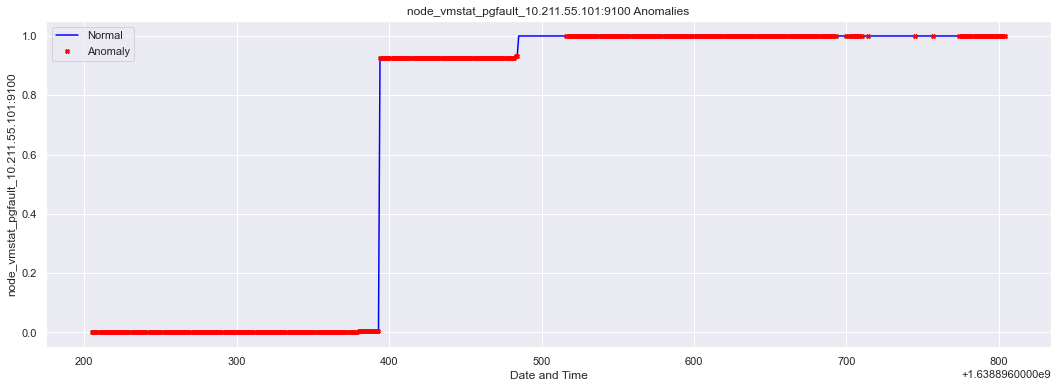

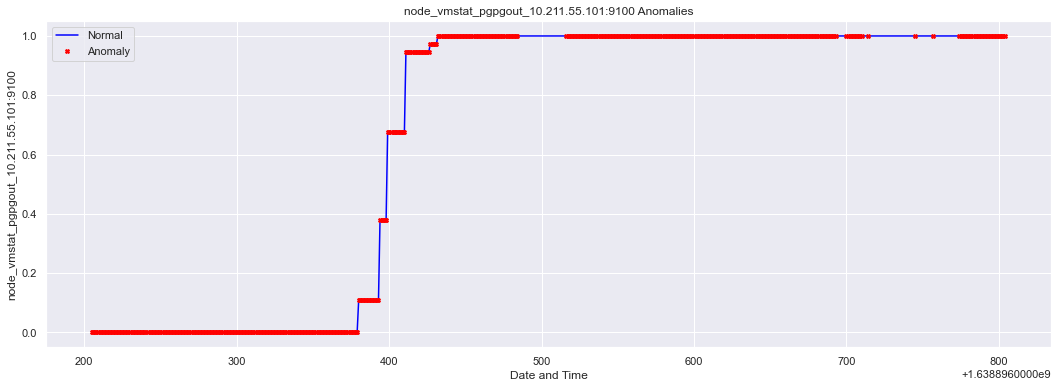

In [74]:
df_plot = df_bd_lab_rm_scaled
print(df_plot.columns.values)
col_names_plt = list(df_plot.columns.values)
df_plot['anomaly'] = pred_2

for feature in col_names_plt:
    if feature == 'epoch' or feature == 'anomaly':
        pass
    else:
        # fig, ax = plt.subplots(figsize=(15,10))
        a = df_plot[df_plot['anomaly'] == -1] #anomaly
        _ = plt.figure(figsize=(18,6))
        _ = plt.plot(df_plot[feature], color='blue', label='Normal')
        _ = plt.plot(a[feature], linestyle='none', marker='X', color='red', markersize=4, label='Anomaly')
        _ = plt.xlabel('Date and Time')
        _ = plt.ylabel(f'{feature}')
        _ = plt.title(f'{feature} Anomalies')
        _ = plt.legend(loc='best')
        plt.show();